#Setup

In [ ]:
!pip install scipy==1.12

#modeling libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Bidirectional

#processing libraries
import gc
import psutil
import multiprocessing
import re
import tqdm
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import zipfile
import io
import os
import ast
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import string
stop_words = set(stopwords.words("english"))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 24.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.
osqp 0.6.7.post0 requires scipy!=1.12.0,>=0.13.2, but you have scipy 1.12.0 which is incompatible.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# functions
def extract_main_headline(row_headline):
    try:
        # Ensure the row_headline is a valid string representation of a dictionary
        if isinstance(row_headline, str):
            headline_dict = ast.literal_eval(row_headline)
            return headline_dict.get('main')
    except (ValueError, SyntaxError):
        # Return None or a default value if parsing fails
        return None

# Function to split the dataset based on years
def split_data_by_year(df, dropnulls = False):
    if dropnulls==True:
        df = df.dropna()
    training_set = df[df['year'] < 2023]
    validation_set = df[df['year'] == 2023]
    test_set = df[df['year'] == 2024]

    return training_set, validation_set, test_set


from nltk.tokenize import word_tokenize
import string



def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if word in stop_words or not word.isalnum():
                continue
            tokens.append(word.lower())
    return tokens

In [ ]:
with zipfile.ZipFile('/content/drive/MyDrive/207 Final Proj/rest.zip', 'r') as zip_ref:
    with zip_ref.open(zip_ref.namelist()[0]) as file:
        rp = pd.read_csv(file)

fp=pd.read_csv('/content/drive/MyDrive/207 Final Proj/front_pages')

<ipython-input-5-5651549da0fc>:3: DtypeWarning: Columns (5,23,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  rp = pd.read_csv(file)


In [ ]:
from tensorflow import keras
from keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, InputLayer
from tensorflow.keras.optimizers import Adam


# Preprocessing

In [ ]:
fp['target'] = 1 #denote front page article
rp['target'] = 0 #denote regular page article
df = pd.concat([fp,rp])

In [ ]:
# # take out "CITY – " which can also be "CITY, COUNTRY – "
# pattern = r".*—\s*"
# df['lead_paragraph'] = df["lead_paragraph"].apply(lambda sentence: re.sub(pattern, "", sentence))

In [ ]:
df['year'] = pd.to_datetime(df['pub_date'], errors='coerce').dt.year
df['main_headline']=df['headline'].apply(lambda row_headline: extract_main_headline(row_headline))
df['combined_text'] = df['main_headline'] + ' ' + df['snippet'] + ' ' + df['lead_paragraph']
df=df[df['year']!=2007] #not sure why these are in here

In [ ]:
#train test split
train, val, test = split_data_by_year(df, dropnulls = True)
train['target'].value_counts(normalize=True) #dropping nulls actually improves the class imbalance compared to not dropping nulls; presumably less nulls in front pages

target
0    0.878005
1    0.121995
Name: proportion, dtype: float64

In [ ]:
test['combined_text'] = test["combined_text"].apply(tokenize_text)
val['combined_text'] = val["combined_text"].apply(tokenize_text)


## run if not loading from save

In [ ]:
train['combined_text'] = train["combined_text"].apply(tokenize_text)

In [ ]:
# balance dataset

from sklearn.utils import resample

majority_class = train['target'].value_counts().idxmax()
minority_class = train['target'].value_counts().idxmin()

df_majority = train[train['target'] == majority_class]
df_minority = train[train['target'] == minority_class]

# Calculate the target number of minority samples for a 60-40 split
target_minority_count = int(len(df_majority) * 0.4 / 0.6)

# Resample the minority class to the target size
if len(df_minority) < target_minority_count:
    df_minority_resampled = resample(df_minority,
                                     replace=True,
                                     n_samples=target_minority_count,
                                     random_state=42)
else:
    df_minority_resampled = resample(df_minority,
                                     replace=False,
                                     n_samples=target_minority_count,
                                     random_state=42)

# Combine the majority class with the resampled minority class
df_balanced = pd.concat([df_majority, df_minority_resampled])

df_balanced['target'].value_counts(normalize=True)

target
0    0.600001
1    0.399999
Name: proportion, dtype: float64

In [ ]:
df_balanced.sort_values(by=['pub_date'], inplace=True)
df_balanced.reset_index(drop=True,inplace=True)

val.sort_values(by=['pub_date'], inplace=True)
val.reset_index(drop=True,inplace=True)


In [ ]:
#train the doc2vec models
assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

# initialize doc2vec models on BALANCED data
workers = multiprocessing.cpu_count()
dboww_mod_tr = Doc2Vec(
    dm=0,
    dbow_words=0,
    vector_size=50, #num tokens
    window=4, #words to consider as context
    workers=workers,
    hs=1,
    negative=0,
    epochs=20, #idk did this after reading stuff online
    min_count=5, #has to appear only 5x to be counted
)
dm_mod_tr = Doc2Vec(
    dm=1, #distributed memory
    dm_mean = 1, #use mean of context word vectors
    alpha=0.05, #increased the learning rate
    comment="alpha=0.05",
    vector_size=50,
    window=4,
    workers=workers,
    hs=1,
    negative=0,
    epochs=20,
    min_count=1,
)


model_list = [dboww_mod_tr, dm_mod_tr]

docs = [
    TaggedDocument(doc, [i]) for i, doc in enumerate(df_balanced["combined_text"])
]
for model in model_list:
    model.build_vocab(docs)
    print("%s vocabulary scanned & state initialized" % model)
for model in model_list:
    print("Training %s" % model)
    model.train(docs, total_examples=len(docs), epochs=model.epochs)


Doc2Vec<dbow,d50,hs,mc5,s0.001,t8> vocabulary scanned & state initialized
Doc2Vec<dm/m,d50,hs,w4,s0.001,t8> vocabulary scanned & state initialized
Training Doc2Vec<dbow,d50,hs,mc5,s0.001,t8>
Training Doc2Vec<dm/m,d50,hs,w4,s0.001,t8>


In [ ]:
df_balanced['dm_vec'] = [list(row) for row in dm_mod_tr.dv.vectors]
df_balanced['dbow_vec'] = [list(row) for row in dboww_mod_tr.dv.vectors]

In [ ]:

df_balanced['dv_mean'] = df_balanced.apply(lambda row: np.mean([np.array(row['dm_vec']), np.array(row['dbow_vec'])], axis=0), axis=1)


In [ ]:
df_balanced.to_csv('/content/drive/MyDrive/207 Final Proj/df_balanced.gz', compression='gzip')

## Run if loading from save

In [ ]:
# load document vector models
dm_mod_tr = Doc2Vec.load('/content/drive/MyDrive/dm_mod_tr.model')
dboww_mod_tr = Doc2Vec.load('/content/drive/MyDrive/dboww_mod_tr.model')
df_balanced = pd.read_csv('/content/drive/MyDrive/207 Final Proj/df_balanced.gz', compression='gzip')

In [ ]:
df_balanced['dm_vec'] = [list(row) for row in dm_mod_tr.dv.vectors]
df_balanced['dbow_vec'] = [list(row) for row in dboww_mod_tr.dv.vectors]
df_balanced['dv_mean'] = df_balanced.apply(lambda row: np.mean([np.array(row['dm_vec']), np.array(row['dbow_vec'])], axis=0), axis=1)


## Preprocessing for Modeling

In [ ]:
# usign document vector model trained on the training set, infer the valiation set docvecs
val_docs = [
    TaggedDocument(doc, [i]) for i, doc in enumerate(val["combined_text"])
]

val_dm_vecs=[]
for doc_id in range(len(val_docs)):
    val_dm_vecs.append(dm_mod_tr.infer_vector(val_docs[doc_id].words))



val_dbow_vecs=[]
for doc_id in range(len(val_docs)):
    val_dbow_vecs.append(dboww_mod_tr.infer_vector(val_docs[doc_id].words))

In [ ]:

val['dm_vec'] = [list(row) for row in val_dbow_vecs]
val['dbow_vec'] = [list(row) for row in val_dm_vecs]
val['dv_mean'] = val.apply(lambda row: np.mean([np.array(row['dm_vec']), np.array(row['dbow_vec'])], axis=0), axis=1)


In [ ]:
df_balanced.sort_values(by=['pub_date'], inplace=True)
df_balanced.reset_index(drop=True,inplace=True)



val.sort_values(by=['pub_date'], inplace=True)
val.reset_index(drop=True,inplace=True)

In [ ]:
#Split into X and Y sets, test and val

X_train = df_balanced.drop(columns=['target'])
y_train = df_balanced['target']



X_val = val.drop(columns=['target'])
y_val = val['target']

In [ ]:
#vocabulary for top 10 values for the selected features to avoid sparsity problem

sectionname_vocab =  X_train['section_name'].value_counts().nlargest(10).index.to_list()
newsdesk_vocab = X_train['news_desk'].value_counts().nlargest(10).index.to_list()
tom_vocab = X_train['type_of_material'].value_counts().nlargest(10).index.to_list()



In [ ]:
X_tr=X_train[['section_name','news_desk','type_of_material',
         'word_count', 'num_subjects','num_persons','num_glocs',
          'dv_mean']]



X_val=X_val[['section_name','news_desk','type_of_material',
         'word_count', 'num_subjects','num_persons','num_glocs',
          'dv_mean']]







# Modeling

In [ ]:

#inspiration: https://stackoverflow.com/users/8163053/th%c3%a9o-rubenach

#max_length=X_tr2['combined_text'].apply(lambda x: len(x.split(' '))).sort_values(ascending=False).max()


class SequenceGenerator(Sequence):
    def __init__(self, features, labels, seq_length=30, batch_size=10):
        self.features = features
        self.labels = labels
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.indices = np.arange(len(self.features) - self.seq_length + 1)

        # Initialize StringLookup layers with vocabularies
        self.section_name_lookup = tf.keras.layers.StringLookup(vocabulary=sectionname_vocab, oov_token='OOV', dtype='int64')
        self.news_desk_lookup = tf.keras.layers.StringLookup(vocabulary=newsdesk_vocab, oov_token='OOV', dtype='int64')
        self.type_of_material_lookup = tf.keras.layers.StringLookup(vocabulary=tom_vocab, oov_token='OOV', dtype='int64')


    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_features = []
        batch_labels = []

        for ind in batch_indices:
            start_idx = ind
            end_idx = start_idx + self.seq_length

            # Extract cols
            section_name = self.features.iloc[start_idx:end_idx, 0].values
            news_desk = self.features.iloc[start_idx:end_idx, 1].values
            type_of_material = self.features.iloc[start_idx:end_idx, 2].values

            # One-hot encoding of categoricals using the vocabularies
            section_name_oh = self.section_name_lookup(section_name).numpy().reshape(-1, 1)
            news_desk_oh = self.news_desk_lookup(news_desk).numpy().reshape(-1, 1)
            type_of_material_oh = self.type_of_material_lookup(type_of_material).numpy().reshape(-1, 1)

            # Extract non-OH features
            word_count = self.features.iloc[start_idx:end_idx, 3].values.reshape(-1, 1)
            num_subjects = self.features.iloc[start_idx:end_idx, 4].values.reshape(-1, 1)
            num_persons = self.features.iloc[start_idx:end_idx, 5].values.reshape(-1, 1)
            num_glocs = self.features.iloc[start_idx:end_idx, 6].values.reshape(-1, 1)
            dv_mean = np.vstack(self.features.iloc[start_idx:end_idx, 7].values)


           # Prepare feature set
            features = np.concatenate([section_name_oh, news_desk_oh, type_of_material_oh,
                                      word_count, num_subjects, num_persons, num_glocs, dv_mean], axis=-1)

            batch_features.append(features)
            batch_labels.append(self.labels.iloc[end_idx - 1])  # Label for the end of the sequence

        return np.array(batch_features, dtype='float64'), np.array(batch_labels, dtype='float64') #can't be object dtype


    def on_epoch_end(self):
        np.random.shuffle(self.indices)

## GRU

### Basic GRU (seq=7, batch=10)

In [ ]:
#initialize generators
train_generator = SequenceGenerator(X_tr, y_train, seq_length=7, batch_size=10)
val_generator = SequenceGenerator(X_val, y_val, seq_length=7, batch_size=10)


In [ ]:
batch_features, batch_labels = train_generator[0] #for shape checking etc
batch_features.shape, batch_labels.shape  #expected - batch size, time_step, num_features

((10, 7, 57), (10,))

In [ ]:


def build_model(seq_length, num_features):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(InputLayer(input_shape=(seq_length, num_features)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(layers.GRU(units=20))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=20, activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid')) #binary classification
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall'),
                          keras.metrics.BinaryAccuracy(name='accuracy')
                          ])

    return model


In [ ]:


# Build and compile the model
num_feat=train_generator.features.dv_mean[0].shape[0] + len(list(X_tr.columns))-1
model = build_model(seq_length= 7, num_features=num_feat)

# Print model summary to verify input shape and architecture
model.summary()




NameError: name 'train_generator' is not defined

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoints/checkpoint-{epoch:02d}.keras',
    save_weights_only=False,  # Save the entire model (not just weights)
    monitor='val_precision',  # Monitor validation precision
    mode='max',  # Save the model with max validation precision
    save_best_only=True,  # Save only the best model
    save_freq='epoch'  # Save at the end of each epoch
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    verbose=1,
    callbacks=[checkpoint_callback]  #checkpoint callback lol
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13445/13445 ━━━━━━━━━━━━━━━━━━━━ 458s 34ms/step - accuracy: 0.8722 - loss: 0.2990 - precision: 0.8521 - recall: 0.8346 - val_accuracy: 0.9046 - val_loss: 0.2362 - val_precision: 0.8982 - val_recall: 0.6819
Epoch 2/5
13445/13445 ━━━━━━━━━━━━━━━━━━━━ 445s 33ms/step - accuracy: 0.9585 - loss: 0.1144 - precision: 0.9553 - recall: 0.9411 - val_accuracy: 0.9358 - val_loss: 0.1690 - val_precision: 0.8784 - val_recall: 0.8519
Epoch 3/5
13445/13445 ━━━━━━━━━━━━━━━━━━━━ 446s 33ms/step - accuracy: 0.9678 - loss: 0.0904 - precision: 0.9652 - recall: 0.9535 - val_accuracy: 0.9425 - val_loss: 0.1571 - val_precision: 0.9077 - val_recall: 0.8478
Epoch 4/5
13445/13445 ━━━━━━━━━━━━━━━━━━━━ 442s 33ms/step - accuracy: 0.9723 - loss: 0.0791 - precision: 0.9692 - recall: 0.9617 - val_accuracy: 0.9446 - val_loss: 0.1517 - val_precision: 0.9128 - val_recall: 0.8519
Epoch 5/5
13445/13445 ━━━━━━━━━━━━━━━━━━━━ 440s 33ms/step - accuracy: 0.9719 - loss: 0.0772 - precision: 0.9684 - recall: 0.9607 - val_accuracy: 0

### experiment 2 - longer seq length (seq=14, batch=10)

In [ ]:
#initialize generators
train_generator_seq = SequenceGenerator(X_tr, y_train, seq_length=14, batch_size=10)
val_generator_seq = SequenceGenerator(X_val, y_val, seq_length=14, batch_size=10)


In [ ]:
model_seq = build_model(seq_length=14, num_features=num_feat)

# Print model summary to verify input shape and architecture
model_seq.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_4                │ (None, 14, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

In [ ]:
history_seq = model_seq.fit(
    train_generator_seq,
    validation_data=val_generator_seq,
    epochs=5, #keeping epochs=5
    verbose=1,
    callbacks=[checkpoint_callback]  #checkpoint callback lol
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13444/13444 ━━━━━━━━━━━━━━━━━━━━ 454s 34ms/step - accuracy: 0.8752 - loss: 0.2924 - precision: 0.8607 - recall: 0.8177 - val_accuracy: 0.9007 - val_loss: 0.2498 - val_precision: 0.9139 - val_recall: 0.6493
Epoch 2/5
13444/13444 ━━━━━━━━━━━━━━━━━━━━ 452s 34ms/step - accuracy: 0.9524 - loss: 0.1260 - precision: 0.9446 - recall: 0.9354 - val_accuracy: 0.9253 - val_loss: 0.1919 - val_precision: 0.8264 - val_recall: 0.8736
Epoch 3/5
13444/13444 ━━━━━━━━━━━━━━━━━━━━ 452s 34ms/step - accuracy: 0.9645 - loss: 0.0970 - precision: 0.9569 - recall: 0.9541 - val_accuracy: 0.9345 - val_loss: 0.1796 - val_precision: 0.8657 - val_recall: 0.8622
Epoch 4/5
13444/13444 ━━━━━━━━━━━━━━━━━━━━ 453s 34ms/step - accuracy: 0.9689 - loss: 0.0864 - precision: 0.9627 - recall: 0.9594 - val_accuracy: 0.9389 - val_loss: 0.1679 - val_precision: 0.8747 - val_recall: 0.8711
Epoch 5/5
13444/13444 ━━━━━━━━━━━━━━━━━━━━ 452s 34ms/step - accuracy: 0.9691 - loss: 0.0835 - precision: 0.9638 - recall: 0.9590 - val_accuracy: 0

### experiment 3 - larger batch size (seq=14, batch=20)



In [ ]:
#initialize generators
train_generator_batch = SequenceGenerator(X_tr, y_train, seq_length=14, batch_size=20)
val_generator_batch = SequenceGenerator(X_val, y_val, seq_length=14, batch_size=20)


In [ ]:
model_batch = build_model(seq_length=14, num_features=num_feat)

model_batch.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 14, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

In [ ]:


model_batch = build_model(seq_length=14, num_features=num_feat)

model_batch.summary()

history_batch = model_batch.fit(
    train_generator_batch,
    validation_data=val_generator_batch,
    epochs=5, #keeping epochs=5
    verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 14, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6722/6722 ━━━━━━━━━━━━━━━━━━━━ 440s 65ms/step - accuracy: 0.8750 - loss: 0.2874 - precision: 0.8576 - recall: 0.8248 - val_accuracy: 0.9271 - val_loss: 0.1906 - val_precision: 0.8918 - val_recall: 0.7936
Epoch 2/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 440s 65ms/step - accuracy: 0.9650 - loss: 0.0966 - precision: 0.9624 - recall: 0.9496 - val_accuracy: 0.9459 - val_loss: 0.1501 - val_precision: 0.8863 - val_recall: 0.8899
Epoch 3/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 438s 65ms/step - accuracy: 0.9732 - loss: 0.0759 - precision: 0.9703 - recall: 0.9624 - val_accuracy: 0.9454 - val_loss: 0.1487 - val_precision: 0.8950 - val_recall: 0.8760
Epoch 4/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 437s 65ms/step - accuracy: 0.9762 - loss: 0.0665 - precision: 0.9731 - recall: 0.9669 - val_accuracy: 0.9408 - val_loss: 0.1583 - val_precision: 0.8566 - val_recall: 0.9062
Epoch 5/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 439s 65ms/step - accuracy: 0.9783 - loss: 0.0625 - precision: 0.9758 - recall: 0.9698 - val_accuracy: 0.9414 - va

### experiment 4:  seq=21, batch=20

In [ ]:
#initialize generators
train_generator_batch_seq = SequenceGenerator(X_tr, y_train, seq_length=21, batch_size=20)
val_generator_batch_seq = SequenceGenerator(X_val, y_val, seq_length=21, batch_size=20)


In [ ]:
model_batch_seq = build_model(seq_length=21, num_features=num_feat)

# Print model summary to verify input shape and architecture
model_batch_seq.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_7                │ (None, 21, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

In [ ]:
history_batch_seq = model_batch_seq.fit(
    train_generator_batch,
    validation_data=val_generator_batch,
    epochs=5, #keeping epochs=5
    verbose=1,
    callbacks=[checkpoint_callback])

Epoch 1/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 451s 67ms/step - accuracy: 0.9019 - loss: 0.2312 - precision: 0.8773 - recall: 0.8793 - val_accuracy: 0.9265 - val_loss: 0.1919 - val_precision: 0.8193 - val_recall: 0.8915
Epoch 2/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 448s 67ms/step - accuracy: 0.9598 - loss: 0.1080 - precision: 0.9488 - recall: 0.9510 - val_accuracy: 0.9243 - val_loss: 0.1947 - val_precision: 0.8049 - val_recall: 0.9054
Epoch 3/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 446s 66ms/step - accuracy: 0.9658 - loss: 0.0934 - precision: 0.9571 - recall: 0.9571 - val_accuracy: 0.9273 - val_loss: 0.1836 - val_precision: 0.8257 - val_recall: 0.8850
Epoch 4/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 443s 66ms/step - accuracy: 0.9684 - loss: 0.0869 - precision: 0.9598 - recall: 0.9612 - val_accuracy: 0.9351 - val_loss: 0.1694 - val_precision: 0.8544 - val_recall: 0.8809
Epoch 5/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 443s 66ms/step - accuracy: 0.9710 - loss: 0.0799 - precision: 0.9649 - recall: 0.9625 - val_accuracy: 0

## LSTM (seq=14, batch=20)

In [ ]:
def build_lstm(seq_length, num_features):
    model = Sequential()
    model.add(InputLayer(input_shape=(seq_length, num_features)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(layers.LSTM(units=20))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(units=20, activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid')) #binary classification
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall'),
                          keras.metrics.BinaryAccuracy(name='accuracy')
                          ])

    return model





In [ ]:
#initialize generators
train_generator_lstm = SequenceGenerator(X_tr, y_train, seq_length=14, batch_size=20)
val_generator_lstm = SequenceGenerator(X_val, y_val, seq_length=14, batch_size=20)


In [ ]:


model_lstm = build_lstm(seq_length= 14, num_features=57)

# Print model summary to verify input shape and architecture
model_lstm.summary()




In [ ]:
history_lstm = model_lstm.fit(
    train_generator_lstm,
    validation_data=val_generator_lstm,
    epochs=5,
    verbose=1,
    callbacks=[checkpoint_callback]  #checkpoint callback lol
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6722/6722 ━━━━━━━━━━━━━━━━━━━━ 454s 67ms/step - accuracy: 0.8609 - loss: 0.3169 - precision: 0.8376 - recall: 0.8141 - val_accuracy: 0.8895 - val_loss: 0.2523 - val_precision: 0.9079 - val_recall: 0.6028
Epoch 2/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 448s 67ms/step - accuracy: 0.9568 - loss: 0.1160 - precision: 0.9494 - recall: 0.9423 - val_accuracy: 0.9227 - val_loss: 0.1942 - val_precision: 0.8101 - val_recall: 0.8874
Epoch 3/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 449s 67ms/step - accuracy: 0.9691 - loss: 0.0851 - precision: 0.9626 - recall: 0.9600 - val_accuracy: 0.9353 - val_loss: 0.1679 - val_precision: 0.8518 - val_recall: 0.8858
Epoch 4/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 449s 67ms/step - accuracy: 0.9732 - loss: 0.0735 - precision: 0.9681 - recall: 0.9649 - val_accuracy: 0.9308 - val_loss: 0.1762 - val_precision: 0.8351 - val_recall: 0.8883
Epoch 5/5
6722/6722 ━━━━━━━━━━━━━━━━━━━━ 449s 67ms/step - accuracy: 0.9754 - loss: 0.0679 - precision: 0.9711 - recall: 0.9673 - val_accuracy: 0.9379 - va

### experiment 1 - LSTM w longer sequences (seq=21, batch=14)

In [ ]:
model_lstm_seq = build_lstm(seq_length= 21, num_features=num_feat)

# Print model summary to verify input shape and architecture
model_lstm_seq.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_2                │ (None, 21, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 20)                  │           6,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,909 (26.99 KB)

 Trainable params: 6,795 (26.54 KB)

 Non-trainable params: 114 (456.00 B)

In [ ]:
#initialize generators
train_generator_lstm_seq = SequenceGenerator(X_tr, y_train, seq_length=21, batch_size=14)
val_generator_lstm_seq = SequenceGenerator(X_val, y_val, seq_length=21, batch_size=14)


In [ ]:
history_lstm_seq = model_lstm_seq.fit(
    train_generator_lstm_seq,
    validation_data=val_generator_lstm_seq,
    epochs=5,
    verbose=1,
    callbacks=[checkpoint_callback]  #checkpoint callback lol
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9603/9603 ━━━━━━━━━━━━━━━━━━━━ 456s 47ms/step - accuracy: 0.8628 - loss: 0.3091 - precision: 0.8454 - recall: 0.8052 - val_accuracy: 0.9110 - val_loss: 0.2155 - val_precision: 0.8132 - val_recall: 0.8185
Epoch 2/5
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 452s 47ms/step - accuracy: 0.9565 - loss: 0.1162 - precision: 0.9485 - recall: 0.9422 - val_accuracy: 0.9195 - val_loss: 0.1994 - val_precision: 0.8107 - val_recall: 0.8684
Epoch 3/5
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 457s 48ms/step - accuracy: 0.9692 - loss: 0.0855 - precision: 0.9621 - recall: 0.9611 - val_accuracy: 0.9222 - val_loss: 0.1956 - val_precision: 0.8371 - val_recall: 0.8406
Epoch 4/5
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 455s 47ms/step - accuracy: 0.9723 - loss: 0.0761 - precision: 0.9663 - recall: 0.9644 - val_accuracy: 0.9226 - val_loss: 0.1962 - val_precision: 0.8197 - val_recall: 0.8700
Epoch 5/5
9603/9603 ━━━━━━━━━━━━━━━━━━━━ 454s 47ms/step - accuracy: 0.9745 - loss: 0.0697 - precision: 0.9685 - recall: 0.9680 - val_accuracy: 0.9289 - va

# time series cross validation

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
gru_seq=keras.models.load_model("/content/drive/MyDrive/model_seq.keras")
gru_batch=keras.models.load_model("/content/drive/MyDrive/model_batch.keras")
gru_batch_seq=keras.models.load_model("/content/drive/MyDrive/model_batch_seq.keras")
lstm_seq=keras.models.load_model("/content/drive/MyDrive/model_lstm_seq.keras")
lstm=keras.models.load_model("/content/drive/MyDrive/model_lstm.keras")

In [ ]:
train_val=pd.concat([df_balanced.drop_duplicates(subset=['_id']),val], axis=0, ignore_index=True)

In [ ]:
class TSCVSequenceGenerator(SequenceGenerator):
    def __init__(self, features, labels, batch_size, sequence_length):
        self.labels = labels
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.features = features

        self.indices = np.arange(len(self.features) - self.sequence_length + 1)

        # Initialize StringLookup layers with vocabularies
        self.section_name_lookup = tf.keras.layers.StringLookup(vocabulary=sectionname_vocab, oov_token='OOV', dtype='int64')
        self.news_desk_lookup = tf.keras.layers.StringLookup(vocabulary=newsdesk_vocab, oov_token='OOV', dtype='int64')
        self.type_of_material_lookup = tf.keras.layers.StringLookup(vocabulary=tom_vocab, oov_token='OOV', dtype='int64')

        # Attributes to store batches
        self.batch_features = []
        self.batch_labels = []

        # Precompute all batches
        self._precompute_batches()


    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def _precompute_batches(self):
        for idx in range(len(self)):
            batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
            batch_features = []
            batch_labels = []

            for ind in batch_indices:
                start_idx = ind
                end_idx = start_idx + self.sequence_length

                # Ensure the indices are within bounds
                if end_idx > len(self.features):
                    continue

                # Extract cols
                section_name = self.features.iloc[start_idx:end_idx, 0].values
                news_desk = self.features.iloc[start_idx:end_idx, 1].values
                type_of_material = self.features.iloc[start_idx:end_idx, 2].values

                # One-hot encoding of categoricals using the vocabularies
                section_name_oh = self.section_name_lookup(section_name).numpy().reshape(-1, 1)
                news_desk_oh = self.news_desk_lookup(news_desk).numpy().reshape(-1, 1)
                type_of_material_oh = self.type_of_material_lookup(type_of_material).numpy().reshape(-1, 1)

                # Extract non-OH features
                word_count = self.features.iloc[start_idx:end_idx, 3].values.reshape(-1, 1)
                num_subjects = self.features.iloc[start_idx:end_idx, 4].values.reshape(-1, 1)
                num_persons = self.features.iloc[start_idx:end_idx, 5].values.reshape(-1, 1)
                num_glocs = self.features.iloc[start_idx:end_idx, 6].values.reshape(-1, 1)
                dv_mean = np.vstack(self.features.iloc[start_idx:end_idx, 7].values)

                # Prepare feature set
                features = np.concatenate([section_name_oh, news_desk_oh, type_of_material_oh,
                                           word_count, num_subjects, num_persons, num_glocs, dv_mean], axis=-1)

                batch_features.append(features)
                batch_labels.append(self.labels.iloc[end_idx - 1])  # Label for the end of the sequence

            # Store the precomputed batches
            self.batch_features.append(np.array(batch_features, dtype='float64'))
            self.batch_labels.append(np.array(batch_labels, dtype='float64'))

    def __getitem__(self, idx):
        if idx >= len(self.batch_features) or idx >= len(self.batch_labels):
            raise IndexError("Index out of range for precomputed batches")

        return self.batch_features[idx], self.batch_labels[idx]



In [ ]:
# Usage
train_generator_tscv = TSCVSequenceGenerator(X_tr, y_train, batch_size=20, sequence_length=14)
val_generator_tscv = TSCVSequenceGenerator(X_val, y_val, batch_size=20, sequence_length=14)



In [ ]:
# # Initialize lists for collecting true labels and predictions
# y_val_true_list = []
# y_val_pred_list = []

# # Collect true labels and predictions from the validation generator
# for batch_x, batch_y in val_generator:
#     batch_pred = model_batch_tscv.predict(batch_x)
#     y_val_true_list.extend(batch_y)
#     y_val_pred_list.extend((batch_pred > 0.5).astype(int))

# # Convert lists to numpy arrays
# y_val_true = np.array(y_val_true_list)
# y_val_pred = np.array(y_val_pred_list)
# y_val_true = np.array(y_val_true_list).ravel()
# y_val_pred = np.squeeze(np.array(y_val_pred_list))

# # Calculate scores
# precision, recall, f1, accuracy = calculate_scores(y_val_true, y_val_pred)
# model_scores.append((model, precision, recall, f1, accuracy))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_scores

[(<Sequential name=sequential, built=True>,
  0.5067918832802281,
  0.5010764277113615,
  0.48451444353399176,
  0.8868968935888962),
 (<Sequential name=sequential_6, built=True>,
  0.4321092200925314,
  0.5,
  0.46358217554122627,
  0.8642184401850628)]

In [ ]:

X=train_val[['section_name', 'news_desk', 'type_of_material', 'word_count',
       'num_subjects', 'num_persons', 'num_glocs', 'dv_mean']]
y=train_val['target']

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
def calculate_scores(y_true, y_pred):
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    accuracy = accuracy_score(y_true, y_pred)
    return precision, recall, f1, accuracy

In [ ]:

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
tscv = TimeSeriesSplit(n_splits=5)

# Initialize variables to store the best model and scores
best_model = None
best_score = -1
best_params = None
model_scores = []


## Experiment 3 test: GRU seq=14, batch=20

In [ ]:


#seq=14, batch=20 test
for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create generators
    train_generator_batch = TSCVSequenceGenerator(X_train, y_train, batch_size=20, sequence_length=14)
    val_generator_batch = TSCVSequenceGenerator(X_val, y_val, batch_size=20, sequence_length=14)

    #build model
    num_feat=train_generator_batch.features.dv_mean[0].shape[0] + len(list(X_train.columns))-1

    model_batch_tscv = build_model(seq_length=14, num_features=num_feat)
    history_batch_tscv = model_batch_tscv.fit(
      train_generator_batch,
      validation_data=val_generator_batch,
      epochs=5,
      verbose=1)
    # Print model summary to verify input shape and architecture
    model_batch_tscv.summary()



    # Initialize lists for collecting true labels and predictions
    y_val_true_list = []
    y_val_pred_list = []

    # Collect true labels and predictions from the validation generator
    for batch_x, batch_y in val_generator_batch:
        batch_pred = model_batch_tscv.predict(batch_x,verbose=0)
        y_val_true_list.extend(batch_y)
        y_val_pred_list.extend((batch_pred > 0.5).astype(int))

    # Convert lists to numpy arrays
    y_val_true = np.array(y_val_true_list)
    y_val_pred = np.array(y_val_pred_list)
    y_val_true = np.array(y_val_true_list).ravel()
    y_val_pred = np.squeeze(np.array(y_val_pred_list))

    # Calculate scores
    precision, recall, f1, accuracy = calculate_scores(y_val_true, y_val_pred)
    model_scores.append((precision, recall, f1, accuracy))


    # Update the best model if current model is better
    if f1 > best_score:
        best_model = model_batch_tscv
        best_score = f1
        best_params = model_batch_tscv.get_config()


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


 33/807 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.2379 - loss: 0.8537 - precision: 0.1169 - recall: 0.9613

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


807/807 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8084 - loss: 0.3694 - precision: 0.2631 - recall: 0.3775 - val_accuracy: 0.9634 - val_loss: 0.1077 - val_precision: 0.8530 - val_recall: 0.7149
Epoch 2/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9621 - loss: 0.1124 - precision: 0.8220 - recall: 0.6679 - val_accuracy: 0.9667 - val_loss: 0.0971 - val_precision: 0.8678 - val_recall: 0.7405
Epoch 3/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9675 - loss: 0.0999 - precision: 0.8532 - recall: 0.7158 - val_accuracy: 0.9685 - val_loss: 0.0924 - val_precision: 0.8837 - val_recall: 0.7467
Epoch 4/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9700 - loss: 0.0869 - precision: 0.8789 - recall: 0.7439 - val_accuracy: 0.9693 - val_loss: 0.0900 - val_precision: 0.8452 - val_recall: 0.8048
Epoch 5/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9740 - loss: 0.0805 - precision: 0.8825 - recall: 0.7760 - val_accuracy: 0.9690 - val_loss: 0.0900 - val_prec

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 14, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001 (62.51 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

 Optimizer params: 10,592 (41.38 KB)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  33/1615 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.1652 - loss: 0.9007 - precision: 0.0764 - recall: 0.9194

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1615/1615 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8397 - loss: 0.3152 - precision: 0.3187 - recall: 0.3479 - val_accuracy: 0.9549 - val_loss: 0.1224 - val_precision: 0.7693 - val_recall: 0.8118
Epoch 2/5
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9643 - loss: 0.1067 - precision: 0.8263 - recall: 0.7266 - val_accuracy: 0.9608 - val_loss: 0.1092 - val_precision: 0.8371 - val_recall: 0.7749
Epoch 3/5
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9679 - loss: 0.0928 - precision: 0.8646 - recall: 0.7431 - val_accuracy: 0.9630 - val_loss: 0.1040 - val_precision: 0.8408 - val_recall: 0.7963
Epoch 4/5
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9715 - loss: 0.0836 - precision: 0.8843 - recall: 0.7768 - val_accuracy: 0.9637 - val_loss: 0.1021 - val_precision: 0.8226 - val_recall: 0.8314
Epoch 5/5
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9751 - loss: 0.0747 - precision: 0.9072 - recall: 0.7838 - val_accuracy: 0.9645 - val_loss: 0.0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 14, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001 (62.51 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

 Optimizer params: 10,592 (41.38 KB)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  33/2422 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.5113 - loss: 0.7026 - precision: 0.1122 - recall: 0.7766

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9146 - loss: 0.2181 - precision: 0.5854 - recall: 0.4731 - val_accuracy: 0.9565 - val_loss: 0.1150 - val_precision: 0.8925 - val_recall: 0.7602
Epoch 2/5
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9657 - loss: 0.0981 - precision: 0.8605 - recall: 0.7488 - val_accuracy: 0.9595 - val_loss: 0.1039 - val_precision: 0.8585 - val_recall: 0.8277
Epoch 3/5
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9694 - loss: 0.0887 - precision: 0.8740 - recall: 0.7733 - val_accuracy: 0.9606 - val_loss: 0.1011 - val_precision: 0.8976 - val_recall: 0.7904
Epoch 4/5
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9712 - loss: 0.0820 - precision: 0.8970 - recall: 0.7795 - val_accuracy: 0.9609 - val_loss: 0.1021 - val_precision: 0.8878 - val_recall: 0.8036
Epoch 5/5
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9748 - loss: 0.0737 - precision: 0.9043 - recall: 0.8044 - val_accuracy: 0.9617 - val_loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 14, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001 (62.51 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

 Optimizer params: 10,592 (41.38 KB)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  33/3229 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.7189 - loss: 0.6225 - precision: 0.1018 - recall: 0.1999

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3229/3229 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9294 - loss: 0.2028 - precision: 0.6973 - recall: 0.4880 - val_accuracy: 0.9649 - val_loss: 0.0940 - val_precision: 0.9448 - val_recall: 0.8136
Epoch 2/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9638 - loss: 0.1028 - precision: 0.8629 - recall: 0.7636 - val_accuracy: 0.9729 - val_loss: 0.0764 - val_precision: 0.9444 - val_recall: 0.8702
Epoch 3/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9683 - loss: 0.0899 - precision: 0.8802 - recall: 0.7981 - val_accuracy: 0.9759 - val_loss: 0.0723 - val_precision: 0.9315 - val_recall: 0.9057
Epoch 4/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9702 - loss: 0.0845 - precision: 0.8884 - recall: 0.8055 - val_accuracy: 0.9768 - val_loss: 0.0685 - val_precision: 0.9394 - val_recall: 0.9033
Epoch 5/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.9723 - loss: 0.0792 - precision: 0.8990 - recall: 0.8177 - val_accuracy: 0.9773 - val_loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 14, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001 (62.51 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

 Optimizer params: 10,592 (41.38 KB)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  33/4037 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.4520 - loss: 0.7723 - precision: 0.1280 - recall: 0.5994

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4037/4037 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9123 - loss: 0.2143 - precision: 0.6614 - recall: 0.5655 - val_accuracy: 0.9587 - val_loss: 0.1158 - val_precision: 0.9610 - val_recall: 0.8357
Epoch 2/5
4037/4037 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9655 - loss: 0.0967 - precision: 0.8815 - recall: 0.7955 - val_accuracy: 0.9598 - val_loss: 0.1101 - val_precision: 0.9676 - val_recall: 0.8351
Epoch 3/5
4037/4037 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9684 - loss: 0.0903 - precision: 0.8961 - recall: 0.8131 - val_accuracy: 0.9642 - val_loss: 0.0983 - val_precision: 0.9649 - val_recall: 0.8592
Epoch 4/5
4037/4037 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9703 - loss: 0.0817 - precision: 0.8962 - recall: 0.8265 - val_accuracy: 0.9640 - val_loss: 0.0983 - val_precision: 0.9590 - val_recall: 0.8640
Epoch 5/5
4037/4037 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9732 - loss: 0.0766 - precision: 0.9098 - recall: 0.8399 - val_accuracy: 0.9686 - val_loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 14, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001 (62.51 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

 Optimizer params: 10,592 (41.38 KB)

In [ ]:
model_scores[0]=model_scores[0][1:]

Average Precision: 0.8962
Average Recall: 0.8113
Average F1-Score: 0.8515
Average Accuracy: 0.9684

Model classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     12774
         1.0       0.96      0.88      0.92      3360

    accuracy                           0.97     16134
   macro avg       0.97      0.94      0.95     16134
weighted avg       0.97      0.97      0.97     16134



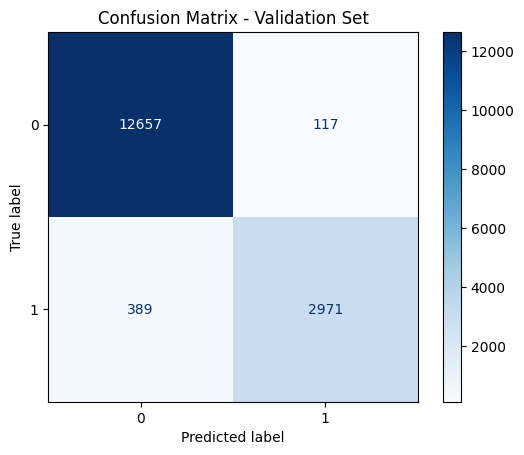

In [ ]:

# Let's use exponential weighting with alpha = 0.9
alpha = 0.9  # Can be hyper-parameterized
num_splits = len(model_scores)

# Calculate weights based on exponential decay
weights = np.array([alpha ** i for i in range(num_splits)])
weights = weights / weights.sum()  # Normalize weights to sum to 1

# Extract the scores for each metric from model_scores
precision_scores = np.array([score[0] for score in model_scores])
recall_scores = np.array([score[1] for score in model_scores])
f1_scores = np.array([score[2] for score in model_scores])
accuracy_scores = np.array([score[3] for score in model_scores])

# Calculate weighted averages for each metric
avg_precision = np.dot(precision_scores, weights)
avg_recall = np.dot(recall_scores, weights)
avg_f1 = np.dot(f1_scores, weights)
avg_accuracy = np.dot(accuracy_scores, weights)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")

print("\nModel classification report:")
print(classification_report(y_val_true, y_val_pred))

cm = confusion_matrix(y_val_true, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

## Experiment 4 test (seq=21, batch=20)

In [ ]:
model_scores_2 = []

In [ ]:


#seq=21, batch=20 test
for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create generators
    train_generator_batch_seq = TSCVSequenceGenerator(X_train, y_train, batch_size=20, sequence_length=21)
    val_generator_batch_seq = TSCVSequenceGenerator(X_val, y_val, batch_size=20, sequence_length=21)

    #build model
    num_feat=train_generator_batch.features.dv_mean[0].shape[0] + len(list(X_train.columns))-1

    model_batch_seq_tscv = build_model(seq_length=21, num_features=num_feat)
    history_batch_seq_tscv = model_batch_seq_tscv.fit(
      train_generator_batch_seq,
      validation_data=val_generator_batch_seq,
      epochs=5,
      verbose=1)
    # Print model summary to verify input shape and architecture
    model_batch_seq_tscv.summary()



    # Initialize lists for collecting true labels and predictions
    y_val_true_list = []
    y_val_pred_list = []

    # Collect true labels and predictions from the validation generator
    for batch_x, batch_y in val_generator_batch_seq:
        batch_pred = model_batch_seq_tscv.predict(batch_x,verbose=0)
        y_val_true_list.extend(batch_y)
        y_val_pred_list.extend((batch_pred > 0.5).astype(int))

    # Convert lists to numpy arrays
    y_val_true = np.array(y_val_true_list)
    y_val_pred = np.array(y_val_pred_list)
    y_val_true = np.array(y_val_true_list).ravel()
    y_val_pred = np.squeeze(np.array(y_val_pred_list))

    # Calculate scores
    precision, recall, f1, accuracy = calculate_scores(y_val_true, y_val_pred)
    model_scores_2.append((precision, recall, f1, accuracy))


    # Update the best model if current model is better
    if f1 > best_score:
        best_model = model_batch_seq_tscv
        best_score = f1
        best_params = model_batch_seq_tscv.get_config()


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


 31/807 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4800 - loss: 0.7285 - precision: 0.0741 - recall: 0.7112

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


807/807 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8552 - loss: 0.3294 - precision: 0.2469 - recall: 0.2251 - val_accuracy: 0.9646 - val_loss: 0.1045 - val_precision: 0.8365 - val_recall: 0.7514
Epoch 2/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9640 - loss: 0.1131 - precision: 0.8263 - recall: 0.7265 - val_accuracy: 0.9695 - val_loss: 0.0927 - val_precision: 0.8980 - val_recall: 0.7438
Epoch 3/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9681 - loss: 0.0936 - precision: 0.8482 - recall: 0.7246 - val_accuracy: 0.9706 - val_loss: 0.0875 - val_precision: 0.8975 - val_recall: 0.7583
Epoch 4/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9716 - loss: 0.0859 - precision: 0.8647 - recall: 0.7558 - val_accuracy: 0.9714 - val_loss: 0.0837 - val_precision: 0.9025 - val_recall: 0.7625
Epoch 5/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9732 - loss: 0.0807 - precision: 0.8829 - recall: 0.7676 - val_accuracy: 0.9715 - val_loss: 0.0842 - val_prec

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 21, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001 (62.51 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

 Optimizer params: 10,592 (41.38 KB)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  31/1614 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6068 - loss: 0.6607 - precision: 0.0925 - recall: 0.4980

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1614/1614 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9078 - loss: 0.2531 - precision: 0.5083 - recall: 0.3720 - val_accuracy: 0.9594 - val_loss: 0.1141 - val_precision: 0.8296 - val_recall: 0.7695
Epoch 2/5
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9659 - loss: 0.1015 - precision: 0.8458 - recall: 0.7356 - val_accuracy: 0.9644 - val_loss: 0.1024 - val_precision: 0.8521 - val_recall: 0.7974
Epoch 3/5
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9718 - loss: 0.0827 - precision: 0.8858 - recall: 0.7681 - val_accuracy: 0.9643 - val_loss: 0.1020 - val_precision: 0.8664 - val_recall: 0.7784
Epoch 4/5
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9737 - loss: 0.0767 - precision: 0.8968 - recall: 0.7930 - val_accuracy: 0.9649 - val_loss: 0.0986 - val_precision: 0.9021 - val_recall: 0.7445
Epoch 5/5
1614/1614 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9756 - loss: 0.0696 - precision: 0.9020 - recall: 0.8030 - val_accuracy: 0.9654 - val_loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 21, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001 (62.51 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

 Optimizer params: 10,592 (41.38 KB)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  30/2422 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.3410 - loss: 0.8164 - precision: 0.0879 - recall: 0.6331

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8949 - loss: 0.2428 - precision: 0.5215 - recall: 0.4633 - val_accuracy: 0.9507 - val_loss: 0.1224 - val_precision: 0.8641 - val_recall: 0.7413
Epoch 2/5
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9669 - loss: 0.0995 - precision: 0.8570 - recall: 0.7578 - val_accuracy: 0.9593 - val_loss: 0.1035 - val_precision: 0.8647 - val_recall: 0.8178
Epoch 3/5
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9679 - loss: 0.0891 - precision: 0.8727 - recall: 0.7612 - val_accuracy: 0.9593 - val_loss: 0.1041 - val_precision: 0.8562 - val_recall: 0.8291
Epoch 4/5
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9725 - loss: 0.0792 - precision: 0.8883 - recall: 0.7969 - val_accuracy: 0.9617 - val_loss: 0.0989 - val_precision: 0.8561 - val_recall: 0.8513
Epoch 5/5
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9736 - loss: 0.0736 - precision: 0.8981 - recall: 0.8045 - val_accuracy: 0.9626 - val_loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 21, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001 (62.51 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

 Optimizer params: 10,592 (41.38 KB)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  30/3229 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.6319 - loss: 0.6496 - precision: 0.1302 - recall: 0.4751

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3229/3229 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9260 - loss: 0.1982 - precision: 0.6815 - recall: 0.5174 - val_accuracy: 0.9679 - val_loss: 0.0879 - val_precision: 0.9163 - val_recall: 0.8652
Epoch 2/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9645 - loss: 0.0963 - precision: 0.8638 - recall: 0.7755 - val_accuracy: 0.9725 - val_loss: 0.0781 - val_precision: 0.9422 - val_recall: 0.8701
Epoch 3/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9689 - loss: 0.0864 - precision: 0.8811 - recall: 0.8025 - val_accuracy: 0.9751 - val_loss: 0.0727 - val_precision: 0.9452 - val_recall: 0.8850
Epoch 4/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9701 - loss: 0.0838 - precision: 0.8888 - recall: 0.8071 - val_accuracy: 0.9754 - val_loss: 0.0715 - val_precision: 0.9625 - val_recall: 0.8701
Epoch 5/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9709 - loss: 0.0805 - precision: 0.8965 - recall: 0.8116 - val_accuracy: 0.9771 - val_loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 21, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001 (62.51 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

 Optimizer params: 10,592 (41.38 KB)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  33/4036 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7567 - loss: 0.6147 - precision: 0.1484 - recall: 0.3009

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4036/4036 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9327 - loss: 0.1922 - precision: 0.7408 - recall: 0.5582 - val_accuracy: 0.9596 - val_loss: 0.1127 - val_precision: 0.9590 - val_recall: 0.8422
Epoch 2/5
4036/4036 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9658 - loss: 0.0964 - precision: 0.8742 - recall: 0.8074 - val_accuracy: 0.9639 - val_loss: 0.0988 - val_precision: 0.9642 - val_recall: 0.8586
Epoch 3/5
4036/4036 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9695 - loss: 0.0858 - precision: 0.8953 - recall: 0.8224 - val_accuracy: 0.9660 - val_loss: 0.0957 - val_precision: 0.9628 - val_recall: 0.8705
Epoch 4/5
4036/4036 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9715 - loss: 0.0816 - precision: 0.8991 - recall: 0.8340 - val_accuracy: 0.9684 - val_loss: 0.0922 - val_precision: 0.9600 - val_recall: 0.8851
Epoch 5/5
4036/4036 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9736 - loss: 0.0747 - precision: 0.9106 - recall: 0.8446 - val_accuracy: 0.9694 - val_loss: 0.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 21, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,001 (62.51 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

 Optimizer params: 10,592 (41.38 KB)

In [ ]:
len(model_scores_2[5:])

5

In [ ]:
model_scores_2_ = model_scores_2[5:]

Average Precision: 0.8991
Average Recall: 0.8368
Average F1-Score: 0.8667
Average Accuracy: 0.9691

Model classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     12768
         1.0       0.96      0.89      0.92      3359

    accuracy                           0.97     16127
   macro avg       0.97      0.94      0.95     16127
weighted avg       0.97      0.97      0.97     16127



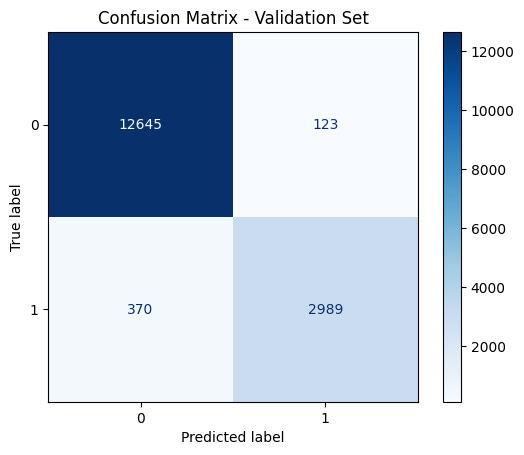

In [ ]:

# Let's use exponential weighting with alpha = 0.9
alpha = 0.9  # Can be hyper-parameterized
num_splits = len(model_scores_2_)

# Calculate weights based on exponential decay
weights = np.array([alpha ** i for i in range(num_splits)])
weights = weights / weights.sum()  # Normalize weights to sum to 1

# Extract the scores for each metric from model_scores
precision_scores = np.array([score[0] for score in model_scores_2_])
recall_scores = np.array([score[1] for score in model_scores_2_])
f1_scores = np.array([score[2] for score in model_scores_2_])
accuracy_scores = np.array([score[3] for score in model_scores_2_])

# Calculate weighted averages for each metric
avg_precision = np.dot(precision_scores, weights)
avg_recall = np.dot(recall_scores, weights)
avg_f1 = np.dot(f1_scores, weights)
avg_accuracy = np.dot(accuracy_scores, weights)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")

print("\nModel classification report:")
print(classification_report(y_val_true, y_val_pred))

cm = confusion_matrix(y_val_true, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

## LSTM testing (seq=14, batch=20

In [ ]:
lstm_scores = []

In [ ]:


#lstm seq=14, batch=20 test
for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create generators
    train_generator_lstm = TSCVSequenceGenerator(X_train, y_train, batch_size=20, sequence_length=14)
    val_generator_lstm = TSCVSequenceGenerator(X_val, y_val, batch_size=20, sequence_length=14)

    #build model
    num_feat=train_generator_lstm.features.dv_mean[0].shape[0] + len(list(X_train.columns))-1

    model_lstm_tscv = build_lstm(seq_length=21, num_features=num_feat)
    history_lstm_tscv = model_lstm_tscv.fit(
      train_generator_lstm,
      validation_data=val_generator_lstm,
      epochs=5,
      verbose=1)




    # Initialize lists for collecting true labels and predictions
    y_val_true_list = []
    y_val_pred_list = []

    # Collect true labels and predictions from the validation generator
    for batch_x, batch_y in val_generator_lstm:
        batch_pred = model_lstm_tscv.predict(batch_x,verbose=0)
        y_val_true_list.extend(batch_y)
        y_val_pred_list.extend((batch_pred > 0.5).astype(int))

    # Convert lists to numpy arrays
    y_val_true = np.array(y_val_true_list)
    y_val_pred = np.array(y_val_pred_list)
    y_val_true = np.array(y_val_true_list).ravel()
    y_val_pred = np.squeeze(np.array(y_val_pred_list))

    # Calculate scores
    precision, recall, f1, accuracy = calculate_scores(y_val_true, y_val_pred)
    lstm_scores.append((precision, recall, f1, accuracy))


    # Update the best model if current model is better
    if f1 > best_score:
        best_model = model_lstm_tscv
        best_score = f1
        best_params = model_lstm_tscv.get_config()


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


 31/807 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8658 - loss: 0.5503 - precision: 0.2991 - recall: 0.1104

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


807/807 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9188 - loss: 0.2655 - precision: 0.4989 - recall: 0.0884 - val_accuracy: 0.9665 - val_loss: 0.1017 - val_precision: 0.8526 - val_recall: 0.7564
Epoch 2/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9674 - loss: 0.1027 - precision: 0.8442 - recall: 0.7029 - val_accuracy: 0.9705 - val_loss: 0.0872 - val_precision: 0.9007 - val_recall: 0.7536
Epoch 3/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9702 - loss: 0.0900 - precision: 0.8656 - recall: 0.7360 - val_accuracy: 0.9713 - val_loss: 0.0861 - val_precision: 0.9307 - val_recall: 0.7343
Epoch 4/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9749 - loss: 0.0759 - precision: 0.8989 - recall: 0.7756 - val_accuracy: 0.9732 - val_loss: 0.0794 - val_precision: 0.9023 - val_recall: 0.7862
Epoch 5/5
807/807 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9764 - loss: 0.0665 - precision: 0.8875 - recall: 0.7945 - val_accuracy: 0.9736 - val_loss: 0.0778 - val_prec

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  33/1615 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4217 - loss: 0.7136 - precision: 0.0864 - recall: 0.6104

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1615/1615 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8936 - loss: 0.2611 - precision: 0.4370 - recall: 0.2988 - val_accuracy: 0.9621 - val_loss: 0.1050 - val_precision: 0.8467 - val_recall: 0.7773
Epoch 2/5
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9694 - loss: 0.0919 - precision: 0.8667 - recall: 0.7493 - val_accuracy: 0.9665 - val_loss: 0.0922 - val_precision: 0.8610 - val_recall: 0.8094
Epoch 3/5
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9720 - loss: 0.0790 - precision: 0.8788 - recall: 0.7739 - val_accuracy: 0.9691 - val_loss: 0.0872 - val_precision: 0.9033 - val_recall: 0.7880
Epoch 4/5
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9758 - loss: 0.0702 - precision: 0.9027 - recall: 0.8059 - val_accuracy: 0.9711 - val_loss: 0.0839 - val_precision: 0.8965 - val_recall: 0.8177
Epoch 5/5
1615/1615 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9770 - loss: 0.0685 - precision: 0.9153 - recall: 0.8100 - val_accuracy: 0.9720 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  33/2422 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6201 - loss: 0.6715 - precision: 0.0673 - recall: 0.2954

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2422/2422 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9185 - loss: 0.2322 - precision: 0.5981 - recall: 0.3499 - val_accuracy: 0.9557 - val_loss: 0.1123 - val_precision: 0.8703 - val_recall: 0.7790
Epoch 2/5
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9661 - loss: 0.0968 - precision: 0.8615 - recall: 0.7464 - val_accuracy: 0.9635 - val_loss: 0.0948 - val_precision: 0.8646 - val_recall: 0.8560
Epoch 3/5
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9722 - loss: 0.0801 - precision: 0.8933 - recall: 0.7959 - val_accuracy: 0.9657 - val_loss: 0.0883 - val_precision: 0.8830 - val_recall: 0.8517
Epoch 4/5
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9767 - loss: 0.0706 - precision: 0.9150 - recall: 0.8213 - val_accuracy: 0.9647 - val_loss: 0.0899 - val_precision: 0.9100 - val_recall: 0.8116
Epoch 5/5
2422/2422 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9763 - loss: 0.0675 - precision: 0.9127 - recall: 0.8181 - val_accuracy: 0.9670 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  32/3229 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.1844 - loss: 0.8166 - precision: 0.1092 - recall: 0.9399

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3229/3229 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8827 - loss: 0.2432 - precision: 0.5205 - recall: 0.4479 - val_accuracy: 0.9706 - val_loss: 0.0849 - val_precision: 0.9410 - val_recall: 0.8574
Epoch 2/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9647 - loss: 0.0992 - precision: 0.8666 - recall: 0.7707 - val_accuracy: 0.9724 - val_loss: 0.0760 - val_precision: 0.9503 - val_recall: 0.8611
Epoch 3/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9697 - loss: 0.0841 - precision: 0.8847 - recall: 0.7995 - val_accuracy: 0.9722 - val_loss: 0.0746 - val_precision: 0.9573 - val_recall: 0.8524
Epoch 4/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9718 - loss: 0.0769 - precision: 0.8950 - recall: 0.8148 - val_accuracy: 0.9751 - val_loss: 0.0678 - val_precision: 0.9702 - val_recall: 0.8603
Epoch 5/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9740 - loss: 0.0738 - precision: 0.9061 - recall: 0.8307 - val_accuracy: 0.9768 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  32/4037 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.4771 - loss: 0.6970 - precision: 0.0967 - recall: 0.4035

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4037/4037 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9196 - loss: 0.1962 - precision: 0.6904 - recall: 0.5281 - val_accuracy: 0.9653 - val_loss: 0.1037 - val_precision: 0.9584 - val_recall: 0.8711
Epoch 2/5
4037/4037 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9678 - loss: 0.0930 - precision: 0.8887 - recall: 0.8098 - val_accuracy: 0.9669 - val_loss: 0.0925 - val_precision: 0.9676 - val_recall: 0.8702
Epoch 3/5
4037/4037 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9721 - loss: 0.0796 - precision: 0.9040 - recall: 0.8401 - val_accuracy: 0.9723 - val_loss: 0.0810 - val_precision: 0.9670 - val_recall: 0.8976
Epoch 4/5
4037/4037 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9746 - loss: 0.0736 - precision: 0.9094 - recall: 0.8547 - val_accuracy: 0.9717 - val_loss: 0.0802 - val_precision: 0.9687 - val_recall: 0.8929
Epoch 5/5
4037/4037 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9755 - loss: 0.0698 - precision: 0.9140 - recall: 0.8576 - val_accuracy: 0.9720 - val_loss: 0.

Average Precision: 0.9172
Average Recall: 0.8469
Average F1-Score: 0.8804
Average Accuracy: 0.9723

Model classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     12774
         1.0       0.97      0.89      0.93      3360

    accuracy                           0.97     16134
   macro avg       0.97      0.94      0.96     16134
weighted avg       0.97      0.97      0.97     16134



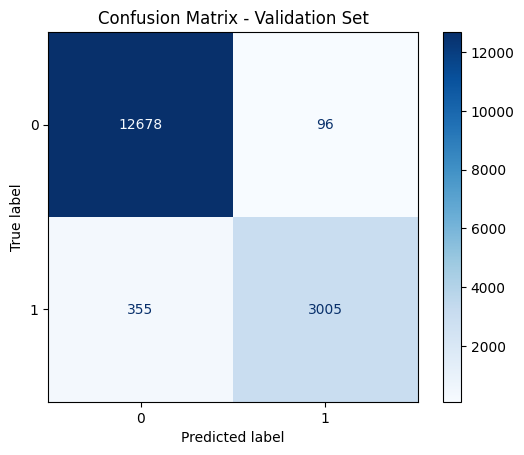

In [ ]:

# Let's use exponential weighting with alpha = 0.9
alpha = 0.9  # Can be hyper-parameterized
num_splits = len(lstm_scores)

# Calculate weights based on exponential decay
weights = np.array([alpha ** i for i in range(num_splits)])
weights = weights / weights.sum()  # Normalize weights to sum to 1

# Extract the scores for each metric from model_scores
precision_scores = np.array([score[0] for score in lstm_scores])
recall_scores = np.array([score[1] for score in lstm_scores])
f1_scores = np.array([score[2] for score in lstm_scores])
accuracy_scores = np.array([score[3] for score in lstm_scores])

# Calculate weighted averages for each metric
avg_precision = np.dot(precision_scores, weights)
avg_recall = np.dot(recall_scores, weights)
avg_f1 = np.dot(f1_scores, weights)
avg_accuracy = np.dot(accuracy_scores, weights)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")

print("\nModel classification report:")
print(classification_report(y_val_true, y_val_pred))

cm = confusion_matrix(y_val_true, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [ ]:
best_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_6                │ (None, 21, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 20)                  │           6,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,501 (80.09 KB)

 Trainable params: 6,795 (26.54 KB)

 Non-trainable params: 114 (456.00 B)

 Optimizer params: 13,592 (53.10 KB)

## LSTM longer sequences testing(seq=21, batch=14)

In [ ]:
lstm_scores_2 = []

In [ ]:


#lstm seq=21, batch=14 test
for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Create generators
    train_generator_lstm_seq = TSCVSequenceGenerator(X_train, y_train, batch_size=14, sequence_length=21)
    val_generator_lstm_seq = TSCVSequenceGenerator(X_val, y_val, batch_size=14, sequence_length=21)

    #build model
    num_feat=train_generator_lstm_seq.features.dv_mean[0].shape[0] + len(list(X_train.columns))-1

    model_lstm_tscv_seq = build_lstm(seq_length=21, num_features=num_feat)
    history_lstm_tscv_seq = model_lstm_tscv_seq.fit(
      train_generator_lstm_seq,
      validation_data=val_generator_lstm_seq,
      epochs=5,
      verbose=1)




    # Initialize lists for collecting true labels and predictions
    y_val_true_list = []
    y_val_pred_list = []

    # Collect true labels and predictions from the validation generator
    for batch_x, batch_y in val_generator_lstm_seq:
        batch_pred = model_lstm_tscv_seq.predict(batch_x,verbose=0)
        y_val_true_list.extend(batch_y)
        y_val_pred_list.extend((batch_pred > 0.5).astype(int))

    # Convert lists to numpy arrays
    y_val_true = np.array(y_val_true_list)
    y_val_pred = np.array(y_val_pred_list)
    y_val_true = np.array(y_val_true_list).ravel()
    y_val_pred = np.squeeze(np.array(y_val_pred_list))

    # Calculate scores
    precision, recall, f1, accuracy = calculate_scores(y_val_true, y_val_pred)
    lstm_scores_2.append((precision, recall, f1, accuracy))


    # Update the best model if current model is better
    if f1 > best_score:
        best_model = model_lstm_tscv_seq
        best_score = f1
        best_params = model_lstm_tscv_seq.get_config()


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  31/1153 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9100 - loss: 0.5490 - precision: 0.0948 - recall: 0.0519

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1153/1153 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9249 - loss: 0.2553 - precision: 0.4886 - recall: 0.0978 - val_accuracy: 0.9673 - val_loss: 0.1007 - val_precision: 0.9039 - val_recall: 0.7098
Epoch 2/5
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9657 - loss: 0.1033 - precision: 0.8348 - recall: 0.7137 - val_accuracy: 0.9716 - val_loss: 0.0836 - val_precision: 0.8906 - val_recall: 0.7784
Epoch 3/5
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9715 - loss: 0.0849 - precision: 0.8641 - recall: 0.7539 - val_accuracy: 0.9740 - val_loss: 0.0770 - val_precision: 0.8909 - val_recall: 0.8089
Epoch 4/5
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9722 - loss: 0.0790 - precision: 0.8695 - recall: 0.7648 - val_accuracy: 0.9749 - val_loss: 0.0768 - val_precision: 0.9391 - val_recall: 0.7694
Epoch 5/5
1153/1153 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9763 - loss: 0.0666 - precision: 0.8929 - recall: 0.7968 - val_accuracy: 0.9759 - val_loss: 0.0769

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  28/2306 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6666 - loss: 0.6488 - precision: 0.0625 - recall: 0.2430

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2306/2306 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9203 - loss: 0.2213 - precision: 0.5866 - recall: 0.3297 - val_accuracy: 0.9625 - val_loss: 0.1040 - val_precision: 0.8344 - val_recall: 0.7992
Epoch 2/5
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9680 - loss: 0.0961 - precision: 0.8676 - recall: 0.7532 - val_accuracy: 0.9679 - val_loss: 0.0906 - val_precision: 0.8728 - val_recall: 0.8111
Epoch 3/5
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9740 - loss: 0.0779 - precision: 0.8899 - recall: 0.7823 - val_accuracy: 0.9676 - val_loss: 0.0910 - val_precision: 0.8473 - val_recall: 0.8408
Epoch 4/5
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9780 - loss: 0.0641 - precision: 0.9048 - recall: 0.8264 - val_accuracy: 0.9696 - val_loss: 0.0856 - val_precision: 0.9016 - val_recall: 0.7950
Epoch 5/5
2306/2306 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9778 - loss: 0.0626 - precision: 0.9152 - recall: 0.8203 - val_accuracy: 0.9687 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  31/3459 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.6990 - loss: 0.6530 - precision: 0.0766 - recall: 0.1756

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3459/3459 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.9281 - loss: 0.2075 - precision: 0.6680 - recall: 0.4047 - val_accuracy: 0.9576 - val_loss: 0.1113 - val_precision: 0.8647 - val_recall: 0.8026
Epoch 2/5
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9672 - loss: 0.0928 - precision: 0.8651 - recall: 0.7578 - val_accuracy: 0.9634 - val_loss: 0.0953 - val_precision: 0.8913 - val_recall: 0.8211
Epoch 3/5
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9699 - loss: 0.0811 - precision: 0.8791 - recall: 0.7741 - val_accuracy: 0.9645 - val_loss: 0.0942 - val_precision: 0.8759 - val_recall: 0.8499
Epoch 4/5
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9747 - loss: 0.0702 - precision: 0.8975 - recall: 0.8117 - val_accuracy: 0.9646 - val_loss: 0.0920 - val_precision: 0.8685 - val_recall: 0.8607
Epoch 5/5
3459/3459 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9766 - loss: 0.0661 - precision: 0.9085 - recall: 0.8250 - val_accuracy: 0.9663 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  31/4613 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.6129 - loss: 0.6665 - precision: 0.1146 - recall: 0.5006

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4613/4613 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.9296 - loss: 0.1904 - precision: 0.7093 - recall: 0.5089 - val_accuracy: 0.9765 - val_loss: 0.0735 - val_precision: 0.9603 - val_recall: 0.8797
Epoch 2/5
4613/4613 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9654 - loss: 0.0970 - precision: 0.8642 - recall: 0.7766 - val_accuracy: 0.9782 - val_loss: 0.0644 - val_precision: 0.9583 - val_recall: 0.8933
Epoch 3/5
4613/4613 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9706 - loss: 0.0817 - precision: 0.8911 - recall: 0.8143 - val_accuracy: 0.9785 - val_loss: 0.0637 - val_precision: 0.9629 - val_recall: 0.8912
Epoch 4/5
4613/4613 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9733 - loss: 0.0771 - precision: 0.9021 - recall: 0.8325 - val_accuracy: 0.9789 - val_loss: 0.0629 - val_precision: 0.9622 - val_recall: 0.8945
Epoch 5/5
4613/4613 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9762 - loss: 0.0680 - precision: 0.9068 - recall: 0.8502 - val_accuracy: 0.9810 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  30/5766 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.5989 - loss: 0.6638 - precision: 0.1379 - recall: 0.3381

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5766/5766 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.9302 - loss: 0.1858 - precision: 0.7550 - recall: 0.5421 - val_accuracy: 0.9647 - val_loss: 0.0993 - val_precision: 0.9703 - val_recall: 0.8565
Epoch 2/5
5766/5766 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9694 - loss: 0.0857 - precision: 0.8956 - recall: 0.8183 - val_accuracy: 0.9634 - val_loss: 0.0996 - val_precision: 0.9766 - val_recall: 0.8446
Epoch 3/5
5766/5766 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9727 - loss: 0.0775 - precision: 0.9048 - recall: 0.8470 - val_accuracy: 0.9681 - val_loss: 0.0878 - val_precision: 0.9715 - val_recall: 0.8723
Epoch 4/5
5766/5766 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9730 - loss: 0.0751 - precision: 0.9076 - recall: 0.8445 - val_accuracy: 0.9718 - val_loss: 0.0807 - val_precision: 0.9705 - val_recall: 0.8919
Epoch 5/5
5766/5766 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9752 - loss: 0.0714 - precision: 0.9145 - recall: 0.8590 - val_accuracy: 0.9743 - val_loss: 0.

Average Precision: 0.9215
Average Recall: 0.8180
Average F1-Score: 0.8659
Average Accuracy: 0.9716

Model classification report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     12768
         1.0       0.97      0.91      0.94      3359

    accuracy                           0.97     16127
   macro avg       0.97      0.95      0.96     16127
weighted avg       0.97      0.97      0.97     16127



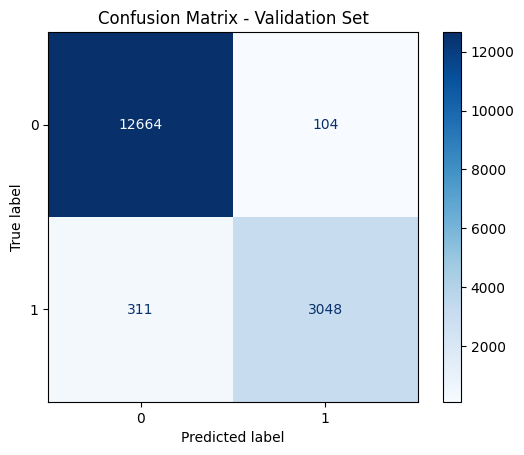

In [ ]:

# Let's use exponential weighting with alpha = 0.9
alpha = 0.9  # Can be hyper-parameterized
num_splits = len(lstm_scores_2)

# Calculate weights based on exponential decay
weights = np.array([alpha ** i for i in range(num_splits)])
weights = weights / weights.sum()  # Normalize weights to sum to 1

# Extract the scores for each metric from model_scores
precision_scores = np.array([score[0] for score in lstm_scores_2])
recall_scores = np.array([score[1] for score in lstm_scores_2])
f1_scores = np.array([score[2] for score in lstm_scores_2])
accuracy_scores = np.array([score[3] for score in lstm_scores_2])

# Calculate weighted averages for each metric
avg_precision = np.dot(precision_scores, weights)
avg_recall = np.dot(recall_scores, weights)
avg_f1 = np.dot(f1_scores, weights)
avg_accuracy = np.dot(accuracy_scores, weights)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")
print(f"Average Accuracy: {avg_accuracy:.4f}")

print("\nModel classification report:")
print(classification_report(y_val_true, y_val_pred))

cm = confusion_matrix(y_val_true, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Validation Set")
plt.show()

In [ ]:
best_model.summary() #best model has the longer sequence length and uses an LSTM layer

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_14               │ (None, 21, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 20)                  │           6,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,501 (80.09 KB)

 Trainable params: 6,795 (26.54 KB)

 Non-trainable params: 114 (456.00 B)

 Optimizer params: 13,592 (53.10 KB)

In [ ]:

print(f'The best model is an LSTM with seq length = 21, batch size = 14, and best f1 score achieved = {best_score}')
print(f'The average f1 score overall of this model was {np.mean(np.array([score[2] for score in lstm_scores_2]))}')





The best model is an LSTM with seq length = 21, batch size = 14, and best f1 score achieved = 0.9362617109506988
The average f1 score overall of this model was 0.8726871728549335


In [ ]:
print(f'LSTM 2 average f1: {np.mean(np.array([score[2] for score in lstm_scores_2]))}')
print(f'LSTM 1 average f1: {np.mean(np.array([score[2] for score in lstm_scores]))}')
print(f'GRU 2 average f1: {np.mean(np.array([score[2] for score in model_scores_2]))}')
print(f'GRU 1 average f1: {np.mean(np.array([score[2] for score in model_scores]))}')


LSTM 2 average f1: 0.8726871728549335
LSTM 1 average f1: 0.8852730496437857
GRU 2 average f1: 0.8878195570089507
GRU 1 average f1: 0.8585544265027779


As we can see, although the second LSTM achieved the highest one-time f1 score, overall the second GRU, and both LSTMs, had very similar average f1 scores across folds.

# Test data evaluation

Because this is a time series dataset, we retrain the models on train + val then infer for test. Otherwise naturally test will perform less reliably than val given that the forecast is farther out.

Ideally the process would be:

1) concatenate train and val data
2) balance
3) train doc2vec models to obtain document vectors
4) continue with modeling

Because of the time and memory required for the document vectors, we will, for now, use the inferred valdiation vectors. Unfortunately, that means that new vocabulary introduced in 2023-2024 is basically going to end up being an OOV token and this will also affect the computation of the paragraph vector as the co-component in the optimization problem. This would be like new politicians or apps which therefore might lead the paragraph vector to fail to capture context accurately.

In [66]:
train_val['target'].value_counts()

target
0    84541
1    12344
Name: count, dtype: int64

In [68]:
# balance dataset

from sklearn.utils import resample

majority_class = train_val['target'].value_counts().idxmax()
minority_class = train_val['target'].value_counts().idxmin()

df_majority = train_val[train_val['target'] == majority_class]
df_minority = train_val[train_val['target'] == minority_class]

# Calculate the target number of minority samples for a 60-40 split
target_minority_count = int(len(df_majority) * 0.4 / 0.6)

# Resample the minority class to the target size
if len(df_minority) < target_minority_count:
    df_minority_resampled = resample(df_minority,
                                     replace=True,
                                     n_samples=target_minority_count,
                                     random_state=42)
else:
    df_minority_resampled = resample(df_minority,
                                     replace=False,
                                     n_samples=target_minority_count,
                                     random_state=42)

# Combine the majority class with the resampled minority class
tv_df_balanced = pd.concat([df_majority, df_minority_resampled])

tv_df_balanced['target'].value_counts(normalize=True)

target
0    0.600003
1    0.399997
Name: proportion, dtype: float64

In [70]:
# usign document vector model trained on the training set, infer the valiation set docvecs
test_docs = [
    TaggedDocument(doc, [i]) for i, doc in enumerate(test["combined_text"])
]

test_dm_vecs=[]
for doc_id in range(len(test_docs)):
    test_dm_vecs.append(dm_mod_tr.infer_vector(test_docs[doc_id].words))



test_dbow_vecs=[]
for doc_id in range(len(test_docs)):
    test_dbow_vecs.append(dboww_mod_tr.infer_vector(test_docs[doc_id].words))
test['dm_vec'] = [list(row) for row in test_dbow_vecs]
test['dbow_vec'] = [list(row) for row in test_dm_vecs]
test['dv_mean'] = test.apply(lambda row: np.mean([np.array(row['dm_vec']), np.array(row['dbow_vec'])], axis=0), axis=1)


In [71]:
X_trv= tv_df_balanced[['section_name','news_desk','type_of_material',
         'word_count', 'num_subjects','num_persons','num_glocs',
          'dv_mean']]



X_test =test[['section_name','news_desk','type_of_material',
         'word_count', 'num_subjects','num_persons','num_glocs',
          'dv_mean']]







In [72]:
Y_trv=tv_df_balanced['target']
Y_test=test['target']

In [73]:
#vocabulary for top 10 values for the selected features to avoid sparsity problem

sectionname_vocab =  X_trv['section_name'].value_counts().nlargest(10).index.to_list()
newsdesk_vocab = X_trv['news_desk'].value_counts().nlargest(10).index.to_list()
tom_vocab = X_trv['type_of_material'].value_counts().nlargest(10).index.to_list()



In [79]:

test_gru_batch = build_model(seq_length=14, num_features=57)
#initialize generators
tv_generator_batch = SequenceGenerator(X_trv, Y_trv, seq_length=14, batch_size=20)
test_generator_batch = SequenceGenerator(X_test, Y_test, seq_length=14, batch_size=20)

test_gru_batch.summary()

history_gru_batch_test = test_gru_batch.fit(
    tv_generator_batch,
    validation_data=test_generator_batch,
    epochs=5,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 14, 57)              │             228 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 20)                  │           4,740 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,295 (20.68 KB)

 Non-trainable params: 114 (456.00 B)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7045/7045 ━━━━━━━━━━━━━━━━━━━━ 454s 64ms/step - accuracy: 0.8874 - loss: 0.2020 - precision: 0.8911 - recall: 0.7969 - val_accuracy: 0.9647 - val_loss: 0.1034 - val_precision: 0.8945 - val_recall: 0.9932
Epoch 2/5
7045/7045 ━━━━━━━━━━━━━━━━━━━━ 455s 65ms/step - accuracy: 0.9994 - loss: 0.0018 - precision: 0.9994 - recall: 0.9992 - val_accuracy: 0.9971 - val_loss: 0.0200 - val_precision: 0.9899 - val_recall: 1.0000
Epoch 3/5
7045/7045 ━━━━━━━━━━━━━━━━━━━━ 455s 65ms/step - accuracy: 1.0000 - loss: 1.8480e-04 - precision: 1.0000 - recall: 0.9999 - val_accuracy: 0.9976 - val_loss: 0.0227 - val_precision: 0.9916 - val_recall: 1.0000
Epoch 4/5
7045/7045 ━━━━━━━━━━━━━━━━━━━━ 453s 64ms/step - accuracy: 0.9999 - loss: 2.1921e-04 - precision: 0.9999 - recall: 0.9999 - val_accuracy: 0.9981 - val_loss: 0.0192 - val_precision: 0.9933 - val_recall: 1.0000
Epoch 5/5
7045/7045 ━━━━━━━━━━━━━━━━━━━━ 452s 64ms/step - accuracy: 1.0000 - loss: 2.2847e-04 - precision: 0.9999 - recall: 0.9999 - val_accuracy:

In [97]:
test['target'].value_counts(normalize=True)

target
0    0.710855
1    0.289145
Name: proportion, dtype: float64

In [98]:
tv_df_balanced['target'].value_counts(normalize=True)

target
0    0.600003
1    0.399997
Name: proportion, dtype: float64

In [99]:
val['target'].value_counts(normalize=True)

target
0    0.758627
1    0.241373
Name: proportion, dtype: float64

In [104]:
df_balanced[df_balanced['target']==1]['word_count'].describe()

count    53781.000000
mean      1568.539391
std        557.584746
min          0.000000
25%       1287.000000
50%       1462.000000
75%       1676.000000
max      10214.000000
Name: word_count, dtype: float64

In [100]:
val[val['target']==1]['word_count'].describe()

count    1231.000000
mean     1566.114541
std       547.296924
min         0.000000
25%      1285.500000
50%      1447.000000
75%      1665.000000
max      7443.000000
Name: word_count, dtype: float64

In [101]:
test[test['target']==1]['word_count'].describe()

count     602.000000
mean     1529.016611
std       596.003163
min         0.000000
25%      1224.250000
50%      1394.000000
75%      1623.500000
max      5587.000000
Name: word_count, dtype: float64

In [103]:
train_val[train_val['target']==1]['word_count'].describe()

count    12344.000000
mean      1568.286293
std        560.479377
min          0.000000
25%       1286.000000
50%       1461.500000
75%       1675.000000
max      10214.000000
Name: word_count, dtype: float64

In [105]:
train_val[train_val['target']==0]['word_count'].describe()

count    84541.000000
mean       846.876498
std        516.986885
min          0.000000
25%        483.000000
50%        816.000000
75%       1115.000000
max      10237.000000
Name: word_count, dtype: float64

Here, we see the GRU model performed very well on the test data. This could be because it has an extremely similar distribution compared to the validation data; however, given the high scores, there is also a concern of data leakage. We do not currently see evidence of data leakage, so this could also be due to the overreliance on word count as a feature. Future experiences should examine the model used without word count as a feature.

# gridsearchcv (took too long, ignore)

In [ ]:
from tensorflow.keras import layers

In [ ]:
from scikeras.wrappers import KerasClassifier
#modeling libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from scikeras.wrappers import KerasClassifier  # SciKeras wrapper
from tensorflow.keras.utils import Sequence

#preprocessing for data load
import gc
import psutil
import multiprocessing
import re
import tqdm
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import zipfile
import io
import os
import ast
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import string
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Bidirectional, Dropout, InputLayer

In [ ]:
param_grid = {
    'units': [10, 30],
    'dropout_rate': [0.2, 0.4],
    'batch_size': [15, 25],
    'sequence_length': [14, 21, 28]
}


In [ ]:
import pickle

def save_progress(best_params, best_score, filename='grid_search_progress.pkl'):
    with open(filename, 'wb') as f:
        pickle.dump({'best_params': best_params, 'best_score': best_score}, f)

def load_progress(filename='grid_search_progress.pkl'):
    with open(filename, 'rb') as f:
        progress = pickle.load(f)
    return progress['best_params'], progress['best_score']


In [ ]:
def build_gridsearch_model(seq_length, units, dropout_rate,num_features=57):
    tf.keras.backend.clear_session()
    model = Sequential()
    model.add(InputLayer(input_shape=(seq_length, num_features)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(layers.GRU(units=units))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(units=units, activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid')) #binary classification
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall'),
                          keras.metrics.BinaryAccuracy(name='accuracy')
                          ])

    return model

In [ ]:
def grid_search_ts(model_fn, param_grid, X, y, n_splits=5, progress_file='grid_search_progress.pkl'):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    best_params = None
    best_score = -np.inf

    # Load previous progress if exists
    try:
        best_params, best_score = load_progress(progress_file)
        print(f'Loaded progress: Best Parameters: {best_params}, Best Score: {best_score}')
    except FileNotFoundError:
        print('No previous progress found, starting from scratch.')

    # Iterate over all parameter combinations
    for units in param_grid['units']:
        for dropout_rate in param_grid['dropout_rate']:
            for batch_size in param_grid['batch_size']:
                for sequence_length in param_grid['sequence_length']:
                    scores = []
                    for train_idx, val_idx in tscv.split(X):
                        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                        # Create generators with current parameters
                        train_generator = TSCVSequenceGenerator(X_train, y_train, batch_size=batch_size, sequence_length=sequence_length)
                        val_generator = TSCVSequenceGenerator(X_val, y_val, batch_size=batch_size, sequence_length=sequence_length)

                        # Build and train the model
                        num_feat=train_generator.features.dv_mean[0].shape[0] + len(list(X_train.columns))-1

                        model = model_fn(seq_length=sequence_length, num_features=num_feat, units=units, dropout_rate=dropout_rate)
                        history = model.fit(train_generator, validation_data=val_generator, epochs=5, verbose=1)

                        # Evaluate the model
                        y_val_true_list = []
                        y_val_pred_list = []
                        for batch_x, batch_y in val_generator:
                            batch_pred = model.predict(batch_x)
                            y_val_true_list.extend(batch_y)
                            y_val_pred_list.extend((batch_pred > 0.5).astype(int))

                        y_val_true = np.array(y_val_true_list).ravel()
                        y_val_pred = np.array(y_val_pred_list).ravel()
                        f1 = f1_score(y_val_true, y_val_pred)
                        scores.append(f1)

                    # Calculate mean score for this parameter combination
                    mean_score = np.mean(scores)
                    print(f'Params: units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}, sequence_length={sequence_length}, Mean F1 Score: {mean_score}')

                    # Update best parameters if needed
                    if mean_score > best_score:
                        best_score = mean_score
                        best_params = {'units': units, 'dropout_rate': dropout_rate, 'batch_size': batch_size, 'sequence_length': sequence_length}

                        # Save progress
                        save_progress(best_params, best_score, progress_file)

                        print(f'Best Parameters: {best_params}')
                        print(f'Best Score: {best_score}')

    return best_params, best_score


({'units': 10, 'dropout_rate': 0.2, 'batch_size': 15, 'sequence_length': 28},
 0.8670787113566865)

In [57]:
# Parameters
n_splits = 5

# Perform grid search for GRU
best_params, best_score = grid_search_ts(build_gridsearch_model, param_grid, X, y, n_splits=n_splits)

print(f'Best Parameters: {best_params}')
print(f'Best Score: {best_score}')


No previous progress found, starting from scratch.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1076/1076 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.8152 - loss: 0.3824 - precision: 0.1795 - recall: 0.1978 - val_accuracy: 0.9624 - val_loss: 0.1114 - val_precision: 0.8229 - val_recall: 0.7398
Epoch 2/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9587 - loss: 0.1270 - precision: 0.7948 - recall: 0.6707 - val_accuracy: 0.9670 - val_loss: 0.0989 - val_precision: 0.8701 - val_recall: 0.7419
Epoch 3/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9640 - loss: 0.1024 - precision: 0.8148 - recall: 0.7035 - val_accuracy: 0.9692 - val_loss: 0.0904 - val_precision: 0.8816 - val_recall: 0.7578
Epoch 4/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9660 - loss: 0.0982 - precision: 0.8433 - recall: 0.7160 - val_accuracy: 0.9682 - val_loss: 0.0894 - val_precision: 0.8776 - val_recall: 0.7495
Epoch 5/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9703 - loss: 0.0890 - precision: 0.8751 - recall: 0.7475 - val_accuracy: 0.9691 - val_loss: 0.0878

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  33/2153 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6391 - loss: 0.6317 - precision: 0.0580 - recall: 0.2631

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2153/2153 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9106 - loss: 0.2464 - precision: 0.4852 - recall: 0.2998 - val_accuracy: 0.9540 - val_loss: 0.1241 - val_precision: 0.7797 - val_recall: 0.7797
Epoch 2/5
2153/2153 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9619 - loss: 0.1130 - precision: 0.8156 - recall: 0.7199 - val_accuracy: 0.9584 - val_loss: 0.1134 - val_precision: 0.8010 - val_recall: 0.8005
Epoch 3/5
2153/2153 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9694 - loss: 0.0933 - precision: 0.8591 - recall: 0.7641 - val_accuracy: 0.9616 - val_loss: 0.1030 - val_precision: 0.8403 - val_recall: 0.7809
Epoch 4/5
2153/2153 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9694 - loss: 0.0895 - precision: 0.8749 - recall: 0.7602 - val_accuracy: 0.9634 - val_loss: 0.1003 - val_precision: 0.8642 - val_recall: 0.7708
Epoch 5/5
2153/2153 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9717 - loss: 0.0838 - precision: 0.8885 - recall: 0.7685 - val_accuracy: 0.9623 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  31/3229 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.7714 - loss: 0.5810 - precision: 0.0779 - recall: 0.1556

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3229/3229 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9305 - loss: 0.2146 - precision: 0.6686 - recall: 0.4211 - val_accuracy: 0.9529 - val_loss: 0.1218 - val_precision: 0.8144 - val_recall: 0.8305
Epoch 2/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9634 - loss: 0.1062 - precision: 0.8400 - recall: 0.7365 - val_accuracy: 0.9574 - val_loss: 0.1117 - val_precision: 0.8468 - val_recall: 0.8248
Epoch 3/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9675 - loss: 0.0961 - precision: 0.8626 - recall: 0.7702 - val_accuracy: 0.9585 - val_loss: 0.1065 - val_precision: 0.8671 - val_recall: 0.8074
Epoch 4/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9685 - loss: 0.0891 - precision: 0.8738 - recall: 0.7676 - val_accuracy: 0.9569 - val_loss: 0.1075 - val_precision: 0.8614 - val_recall: 0.8008
Epoch 5/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9696 - loss: 0.0876 - precision: 0.8799 - recall: 0.7841 - val_accuracy: 0.9550 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  33/4306 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.7862 - loss: 0.6030 - precision: 0.1380 - recall: 0.3681

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4306/4306 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9228 - loss: 0.2165 - precision: 0.6566 - recall: 0.4103 - val_accuracy: 0.9660 - val_loss: 0.0967 - val_precision: 0.9083 - val_recall: 0.8599
Epoch 2/5
4306/4306 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9589 - loss: 0.1134 - precision: 0.8305 - recall: 0.7505 - val_accuracy: 0.9675 - val_loss: 0.0892 - val_precision: 0.9136 - val_recall: 0.8652
Epoch 3/5
4306/4306 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9641 - loss: 0.1010 - precision: 0.8641 - recall: 0.7714 - val_accuracy: 0.9672 - val_loss: 0.0875 - val_precision: 0.9272 - val_recall: 0.8475
Epoch 4/5
4306/4306 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9673 - loss: 0.0931 - precision: 0.8789 - recall: 0.7802 - val_accuracy: 0.9717 - val_loss: 0.0771 - val_precision: 0.9407 - val_recall: 0.8656
Epoch 5/5
4306/4306 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9674 - loss: 0.0919 - precision: 0.8784 - recall: 0.7891 - val_accuracy: 0.9722 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  30/5382 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.7181 - loss: 0.6294 - precision: 0.1468 - recall: 0.1976

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5382/5382 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9248 - loss: 0.2085 - precision: 0.7114 - recall: 0.5089 - val_accuracy: 0.9584 - val_loss: 0.1183 - val_precision: 0.9474 - val_recall: 0.8473
Epoch 2/5
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9637 - loss: 0.1039 - precision: 0.8660 - recall: 0.7959 - val_accuracy: 0.9619 - val_loss: 0.1041 - val_precision: 0.9519 - val_recall: 0.8607
Epoch 3/5
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9669 - loss: 0.0949 - precision: 0.8867 - recall: 0.8064 - val_accuracy: 0.9639 - val_loss: 0.1005 - val_precision: 0.9596 - val_recall: 0.8631
Epoch 4/5
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9681 - loss: 0.0919 - precision: 0.8921 - recall: 0.8118 - val_accuracy: 0.9663 - val_loss: 0.0971 - val_precision: 0.9450 - val_recall: 0.8902
Epoch 5/5
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9698 - loss: 0.0879 - precision: 0.8962 - recall: 0.8258 - val_accuracy: 0.9657 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  31/1076 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.2994 - loss: 0.8005 - precision: 0.0677 - recall: 0.4896

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1076/1076 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8246 - loss: 0.3958 - precision: 0.1669 - recall: 0.1624 - val_accuracy: 0.9596 - val_loss: 0.1179 - val_precision: 0.8139 - val_recall: 0.7119
Epoch 2/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9556 - loss: 0.1253 - precision: 0.7609 - recall: 0.6276 - val_accuracy: 0.9664 - val_loss: 0.0972 - val_precision: 0.8679 - val_recall: 0.7368
Epoch 3/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9679 - loss: 0.0984 - precision: 0.8446 - recall: 0.7172 - val_accuracy: 0.9669 - val_loss: 0.0953 - val_precision: 0.9048 - val_recall: 0.7043
Epoch 4/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9694 - loss: 0.0953 - precision: 0.8612 - recall: 0.7432 - val_accuracy: 0.9719 - val_loss: 0.0846 - val_precision: 0.8734 - val_recall: 0.8026
Epoch 5/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9697 - loss: 0.0926 - precision: 0.8661 - recall: 0.7530 - val_accuracy: 0.9722 - val_loss: 0.0838

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  30/2152 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.4982 - loss: 0.7029 - precision: 0.0837 - recall: 0.4638

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2152/2152 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8979 - loss: 0.2560 - precision: 0.4462 - recall: 0.3391 - val_accuracy: 0.9544 - val_loss: 0.1206 - val_precision: 0.7580 - val_recall: 0.8265
Epoch 2/5
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9660 - loss: 0.1016 - precision: 0.8263 - recall: 0.7560 - val_accuracy: 0.9611 - val_loss: 0.1102 - val_precision: 0.8066 - val_recall: 0.8253
Epoch 3/5
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9673 - loss: 0.0917 - precision: 0.8457 - recall: 0.7630 - val_accuracy: 0.9621 - val_loss: 0.1041 - val_precision: 0.8414 - val_recall: 0.7849
Epoch 4/5
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9716 - loss: 0.0847 - precision: 0.8815 - recall: 0.7743 - val_accuracy: 0.9622 - val_loss: 0.1051 - val_precision: 0.8954 - val_recall: 0.7219
Epoch 5/5
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9720 - loss: 0.0827 - precision: 0.8862 - recall: 0.7661 - val_accuracy: 0.9632 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  29/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.0995 - loss: 0.9405 - precision: 0.0902 - recall: 0.9420

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3229/3229 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.8363 - loss: 0.3129 - precision: 0.3821 - recall: 0.4829 - val_accuracy: 0.9520 - val_loss: 0.1248 - val_precision: 0.8066 - val_recall: 0.8347
Epoch 2/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9630 - loss: 0.1057 - precision: 0.8243 - recall: 0.7269 - val_accuracy: 0.9577 - val_loss: 0.1096 - val_precision: 0.8971 - val_recall: 0.7658
Epoch 3/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9665 - loss: 0.0978 - precision: 0.8678 - recall: 0.7451 - val_accuracy: 0.9589 - val_loss: 0.1080 - val_precision: 0.8433 - val_recall: 0.8437
Epoch 4/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9690 - loss: 0.0915 - precision: 0.8735 - recall: 0.7683 - val_accuracy: 0.9617 - val_loss: 0.1002 - val_precision: 0.8985 - val_recall: 0.7984
Epoch 5/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9704 - loss: 0.0866 - precision: 0.8852 - recall: 0.7780 - val_accuracy: 0.9634 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  31/4305 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.7590 - loss: 0.6006 - precision: 0.0869 - recall: 0.1901

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4305/4305 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.9215 - loss: 0.2129 - precision: 0.6681 - recall: 0.4399 - val_accuracy: 0.9683 - val_loss: 0.0901 - val_precision: 0.9166 - val_recall: 0.8677
Epoch 2/5
4305/4305 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9638 - loss: 0.1033 - precision: 0.8602 - recall: 0.7642 - val_accuracy: 0.9698 - val_loss: 0.0819 - val_precision: 0.9514 - val_recall: 0.8416
Epoch 3/5
4305/4305 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9677 - loss: 0.0926 - precision: 0.8849 - recall: 0.7779 - val_accuracy: 0.9730 - val_loss: 0.0781 - val_precision: 0.9354 - val_recall: 0.8809
Epoch 4/5
4305/4305 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9681 - loss: 0.0919 - precision: 0.8903 - recall: 0.7844 - val_accuracy: 0.9744 - val_loss: 0.0741 - val_precision: 0.9353 - val_recall: 0.8908
Epoch 5/5
4305/4305 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9678 - loss: 0.0878 - precision: 0.8845 - recall: 0.7961 - val_accuracy: 0.9728 - val_loss: 0.

KeyboardInterrupt: 

In [58]:
# Parameters
n_splits = 5

# Perform grid search for GRU
best_params, best_score = grid_search_ts(build_gridsearch_model, param_grid, X, y, n_splits=n_splits)

print(f'Best Parameters: {best_params}')
print(f'Best Score: {best_score}')


Loaded progress: Best Parameters: {'units': 10, 'dropout_rate': 0.2, 'batch_size': 15, 'sequence_length': 14}, Best Score: 0.8520639165831406
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  33/1076 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7784 - loss: 0.5932 - precision: 0.0602 - recall: 0.1088

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1076/1076 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9066 - loss: 0.3058 - precision: 0.3107 - recall: 0.0836 - val_accuracy: 0.9593 - val_loss: 0.1219 - val_precision: 0.8188 - val_recall: 0.7003
Epoch 2/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9631 - loss: 0.1109 - precision: 0.7829 - recall: 0.6928 - val_accuracy: 0.9664 - val_loss: 0.1011 - val_precision: 0.8413 - val_recall: 0.7702
Epoch 3/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9680 - loss: 0.1070 - precision: 0.8513 - recall: 0.7370 - val_accuracy: 0.9686 - val_loss: 0.0944 - val_precision: 0.8505 - val_recall: 0.7875
Epoch 4/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9675 - loss: 0.0939 - precision: 0.8363 - recall: 0.7342 - val_accuracy: 0.9701 - val_loss: 0.0899 - val_precision: 0.8781 - val_recall: 0.7730
Epoch 5/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9673 - loss: 0.0916 - precision: 0.8399 - recall: 0.7312 - val_accuracy: 0.9702 - val_loss: 0.0883

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  33/2153 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8483 - loss: 0.5560 - precision: 0.0584 - recall: 0.1015

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2153/2153 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9246 - loss: 0.2347 - precision: 0.5509 - recall: 0.2131 - val_accuracy: 0.9556 - val_loss: 0.1189 - val_precision: 0.7980 - val_recall: 0.7696
Epoch 2/5
2153/2153 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9649 - loss: 0.0984 - precision: 0.8201 - recall: 0.7413 - val_accuracy: 0.9589 - val_loss: 0.1110 - val_precision: 0.8122 - val_recall: 0.7886
Epoch 3/5
2153/2153 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9691 - loss: 0.0941 - precision: 0.8690 - recall: 0.7404 - val_accuracy: 0.9590 - val_loss: 0.1104 - val_precision: 0.8362 - val_recall: 0.7548
Epoch 4/5
2153/2153 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9700 - loss: 0.0874 - precision: 0.8814 - recall: 0.7566 - val_accuracy: 0.9600 - val_loss: 0.1074 - val_precision: 0.8244 - val_recall: 0.7833
Epoch 5/5
2153/2153 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9703 - loss: 0.0839 - precision: 0.8856 - recall: 0.7590 - val_accuracy: 0.9615 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  32/3229 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6213 - loss: 0.6453 - precision: 0.0476 - recall: 0.1472

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3229/3229 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9195 - loss: 0.2271 - precision: 0.5911 - recall: 0.3544 - val_accuracy: 0.9494 - val_loss: 0.1293 - val_precision: 0.7781 - val_recall: 0.8593
Epoch 2/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9647 - loss: 0.1046 - precision: 0.8486 - recall: 0.7592 - val_accuracy: 0.9557 - val_loss: 0.1163 - val_precision: 0.8686 - val_recall: 0.7805
Epoch 3/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9664 - loss: 0.0965 - precision: 0.8703 - recall: 0.7417 - val_accuracy: 0.9584 - val_loss: 0.1073 - val_precision: 0.8755 - val_recall: 0.7965
Epoch 4/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9676 - loss: 0.0940 - precision: 0.8802 - recall: 0.7496 - val_accuracy: 0.9588 - val_loss: 0.1026 - val_precision: 0.8834 - val_recall: 0.7904
Epoch 5/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9701 - loss: 0.0857 - precision: 0.8852 - recall: 0.7685 - val_accuracy: 0.9586 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  31/4306 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.4827 - loss: 0.7333 - precision: 0.0875 - recall: 0.5938

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4306/4306 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9083 - loss: 0.2305 - precision: 0.5889 - recall: 0.4739 - val_accuracy: 0.9687 - val_loss: 0.0907 - val_precision: 0.9269 - val_recall: 0.8590
Epoch 2/5
4306/4306 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9623 - loss: 0.1079 - precision: 0.8408 - recall: 0.7725 - val_accuracy: 0.9692 - val_loss: 0.0856 - val_precision: 0.9412 - val_recall: 0.8475
Epoch 3/5
4306/4306 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9649 - loss: 0.0999 - precision: 0.8645 - recall: 0.7760 - val_accuracy: 0.9731 - val_loss: 0.0764 - val_precision: 0.9465 - val_recall: 0.8698
Epoch 4/5
4306/4306 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9675 - loss: 0.0924 - precision: 0.8727 - recall: 0.7928 - val_accuracy: 0.9724 - val_loss: 0.0801 - val_precision: 0.9490 - val_recall: 0.8619
Epoch 5/5
4306/4306 ━━━━━━━━━━━━━━━━━━━━ 24s 5ms/step - accuracy: 0.9680 - loss: 0.0929 - precision: 0.8877 - recall: 0.7861 - val_accuracy: 0.9753 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  32/5382 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.8868 - loss: 0.4838 - precision: 0.2500 - recall: 0.0048        

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5382/5382 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.9283 - loss: 0.1935 - precision: 0.8232 - recall: 0.4609 - val_accuracy: 0.9554 - val_loss: 0.1241 - val_precision: 0.9603 - val_recall: 0.8199
Epoch 2/5
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9615 - loss: 0.1067 - precision: 0.8553 - recall: 0.7886 - val_accuracy: 0.9581 - val_loss: 0.1088 - val_precision: 0.9568 - val_recall: 0.8366
Epoch 3/5
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9664 - loss: 0.0950 - precision: 0.8811 - recall: 0.8054 - val_accuracy: 0.9593 - val_loss: 0.1052 - val_precision: 0.9704 - val_recall: 0.8301
Epoch 4/5
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9689 - loss: 0.0885 - precision: 0.8937 - recall: 0.8150 - val_accuracy: 0.9625 - val_loss: 0.0987 - val_precision: 0.9575 - val_recall: 0.8580
Epoch 5/5
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9700 - loss: 0.0857 - precision: 0.8958 - recall: 0.8278 - val_accuracy: 0.9649 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  30/1076 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7393 - loss: 0.5975 - precision: 0.1421 - recall: 0.3541

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1076/1076 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8994 - loss: 0.3214 - precision: 0.2866 - recall: 0.0907 - val_accuracy: 0.9562 - val_loss: 0.1284 - val_precision: 0.8142 - val_recall: 0.6614
Epoch 2/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9579 - loss: 0.1294 - precision: 0.7910 - recall: 0.6388 - val_accuracy: 0.9659 - val_loss: 0.0993 - val_precision: 0.8371 - val_recall: 0.7687
Epoch 3/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9619 - loss: 0.1092 - precision: 0.8160 - recall: 0.7012 - val_accuracy: 0.9699 - val_loss: 0.0905 - val_precision: 0.8914 - val_recall: 0.7562
Epoch 4/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9673 - loss: 0.0950 - precision: 0.8574 - recall: 0.7252 - val_accuracy: 0.9712 - val_loss: 0.0852 - val_precision: 0.8792 - val_recall: 0.7860
Epoch 5/5
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9723 - loss: 0.0860 - precision: 0.8717 - recall: 0.7638 - val_accuracy: 0.9711 - val_loss: 0.0843

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  30/2152 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7633 - loss: 0.5938 - precision: 0.0574 - recall: 0.0882

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2152/2152 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.9215 - loss: 0.2462 - precision: 0.5569 - recall: 0.2611 - val_accuracy: 0.9582 - val_loss: 0.1160 - val_precision: 0.8261 - val_recall: 0.7594
Epoch 2/5
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9645 - loss: 0.1065 - precision: 0.8282 - recall: 0.7329 - val_accuracy: 0.9623 - val_loss: 0.1026 - val_precision: 0.8543 - val_recall: 0.7701
Epoch 3/5
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9685 - loss: 0.0955 - precision: 0.8645 - recall: 0.7549 - val_accuracy: 0.9653 - val_loss: 0.0955 - val_precision: 0.8575 - val_recall: 0.8010
Epoch 4/5
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9711 - loss: 0.0864 - precision: 0.8796 - recall: 0.7701 - val_accuracy: 0.9652 - val_loss: 0.0959 - val_precision: 0.8610 - val_recall: 0.7950
Epoch 5/5
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9736 - loss: 0.0788 - precision: 0.9082 - recall: 0.7741 - val_accuracy: 0.9674 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  31/3229 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.5219 - loss: 0.6975 - precision: 0.1236 - recall: 0.5105

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3229/3229 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9055 - loss: 0.2414 - precision: 0.5355 - recall: 0.3846 - val_accuracy: 0.9513 - val_loss: 0.1229 - val_precision: 0.8181 - val_recall: 0.8093
Epoch 2/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9628 - loss: 0.1045 - precision: 0.8370 - recall: 0.7265 - val_accuracy: 0.9559 - val_loss: 0.1131 - val_precision: 0.8598 - val_recall: 0.7937
Epoch 3/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9668 - loss: 0.0942 - precision: 0.8756 - recall: 0.7394 - val_accuracy: 0.9558 - val_loss: 0.1126 - val_precision: 0.8486 - val_recall: 0.8074
Epoch 4/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9689 - loss: 0.0885 - precision: 0.8810 - recall: 0.7600 - val_accuracy: 0.9578 - val_loss: 0.1066 - val_precision: 0.8857 - val_recall: 0.7795
Epoch 5/5
3229/3229 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9719 - loss: 0.0819 - precision: 0.9065 - recall: 0.7701 - val_accuracy: 0.9583 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  30/4305 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.5140 - loss: 0.7307 - precision: 0.0798 - recall: 0.4884

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4305/4305 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.9083 - loss: 0.2206 - precision: 0.5870 - recall: 0.4549 - val_accuracy: 0.9665 - val_loss: 0.0914 - val_precision: 0.9323 - val_recall: 0.8371
Epoch 2/5
4305/4305 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9620 - loss: 0.1064 - precision: 0.8524 - recall: 0.7579 - val_accuracy: 0.9717 - val_loss: 0.0806 - val_precision: 0.9314 - val_recall: 0.8755
Epoch 3/5
4305/4305 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9660 - loss: 0.0947 - precision: 0.8750 - recall: 0.7775 - val_accuracy: 0.9733 - val_loss: 0.0745 - val_precision: 0.9530 - val_recall: 0.8644
Epoch 4/5
4305/4305 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9674 - loss: 0.0917 - precision: 0.8844 - recall: 0.7847 - val_accuracy: 0.9751 - val_loss: 0.0708 - val_precision: 0.9413 - val_recall: 0.8892
Epoch 5/5
4305/4305 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9693 - loss: 0.0840 - precision: 0.8872 - recall: 0.7928 - val_accuracy: 0.9756 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  30/5382 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.7088 - loss: 0.6327 - precision: 0.1965 - recall: 0.3667

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5382/5382 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9337 - loss: 0.1928 - precision: 0.7537 - recall: 0.5980 - val_accuracy: 0.9594 - val_loss: 0.1192 - val_precision: 0.9695 - val_recall: 0.8315
Epoch 2/5
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9647 - loss: 0.1013 - precision: 0.8712 - recall: 0.7997 - val_accuracy: 0.9640 - val_loss: 0.1025 - val_precision: 0.9618 - val_recall: 0.8616
Epoch 3/5
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9671 - loss: 0.0931 - precision: 0.8832 - recall: 0.8043 - val_accuracy: 0.9661 - val_loss: 0.0982 - val_precision: 0.9634 - val_recall: 0.8705
Epoch 4/5
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9672 - loss: 0.0911 - precision: 0.8902 - recall: 0.8054 - val_accuracy: 0.9665 - val_loss: 0.0968 - val_precision: 0.9605 - val_recall: 0.8750
Epoch 5/5
5382/5382 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.9693 - loss: 0.0877 - precision: 0.8923 - recall: 0.8196 - val_accuracy: 0.9642 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  30/1075 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5240 - loss: 0.6986 - precision: 0.0430 - recall: 0.3202

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1075/1075 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8659 - loss: 0.3438 - precision: 0.2293 - recall: 0.1571 - val_accuracy: 0.9646 - val_loss: 0.1076 - val_precision: 0.8632 - val_recall: 0.7178
Epoch 2/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9636 - loss: 0.1114 - precision: 0.8067 - recall: 0.6975 - val_accuracy: 0.9698 - val_loss: 0.0928 - val_precision: 0.8598 - val_recall: 0.7913
Epoch 3/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9667 - loss: 0.1032 - precision: 0.8387 - recall: 0.7443 - val_accuracy: 0.9703 - val_loss: 0.0902 - val_precision: 0.9199 - val_recall: 0.7323
Epoch 4/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9667 - loss: 0.0954 - precision: 0.8555 - recall: 0.7032 - val_accuracy: 0.9727 - val_loss: 0.0819 - val_precision: 0.8767 - val_recall: 0.8086
Epoch 5/5
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9718 - loss: 0.0846 - precision: 0.8622 - recall: 0.7823 - val_accuracy: 0.9718 - val_loss: 0.0815

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  28/2152 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5799 - loss: 0.6611 - precision: 0.0787 - recall: 0.2851

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2152/2152 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.9080 - loss: 0.2524 - precision: 0.4754 - recall: 0.2905 - val_accuracy: 0.9568 - val_loss: 0.1219 - val_precision: 0.8274 - val_recall: 0.7403
Epoch 2/5
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9626 - loss: 0.1102 - precision: 0.8120 - recall: 0.7204 - val_accuracy: 0.9589 - val_loss: 0.1151 - val_precision: 0.8552 - val_recall: 0.7296
Epoch 3/5
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9665 - loss: 0.1010 - precision: 0.8480 - recall: 0.7483 - val_accuracy: 0.9633 - val_loss: 0.1032 - val_precision: 0.8495 - val_recall: 0.7879
Epoch 4/5
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9691 - loss: 0.0905 - precision: 0.8560 - recall: 0.7560 - val_accuracy: 0.9658 - val_loss: 0.0975 - val_precision: 0.8651 - val_recall: 0.7962
Epoch 5/5
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9734 - loss: 0.0784 - precision: 0.8905 - recall: 0.7824 - val_accuracy: 0.9654 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  29/3228 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.2328 - loss: 0.9278 - precision: 0.0741 - recall: 0.9102

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3228/3228 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.8764 - loss: 0.2668 - precision: 0.4704 - recall: 0.4359 - val_accuracy: 0.9555 - val_loss: 0.1186 - val_precision: 0.8668 - val_recall: 0.7808
Epoch 2/5
3228/3228 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9634 - loss: 0.1071 - precision: 0.8427 - recall: 0.7370 - val_accuracy: 0.9594 - val_loss: 0.1051 - val_precision: 0.8956 - val_recall: 0.7818
Epoch 3/5
3228/3228 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9669 - loss: 0.0966 - precision: 0.8672 - recall: 0.7522 - val_accuracy: 0.9604 - val_loss: 0.1005 - val_precision: 0.8826 - val_recall: 0.8059
Epoch 4/5
3228/3228 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9690 - loss: 0.0897 - precision: 0.8812 - recall: 0.7637 - val_accuracy: 0.9638 - val_loss: 0.0945 - val_precision: 0.9097 - val_recall: 0.8040
Epoch 5/5
3228/3228 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9717 - loss: 0.0817 - precision: 0.8897 - recall: 0.7887 - val_accuracy: 0.9617 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  30/4305 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.6600 - loss: 0.6385 - precision: 0.1391 - recall: 0.4682

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4305/4305 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.9253 - loss: 0.2086 - precision: 0.6800 - recall: 0.4939 - val_accuracy: 0.9700 - val_loss: 0.0872 - val_precision: 0.9241 - val_recall: 0.8713
Epoch 2/5
4305/4305 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9642 - loss: 0.1005 - precision: 0.8627 - recall: 0.7748 - val_accuracy: 0.9740 - val_loss: 0.0773 - val_precision: 0.9428 - val_recall: 0.8800
Epoch 3/5
4305/4305 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9673 - loss: 0.0910 - precision: 0.8720 - recall: 0.7926 - val_accuracy: 0.9761 - val_loss: 0.0721 - val_precision: 0.9405 - val_recall: 0.8969
Epoch 4/5
4305/4305 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - accuracy: 0.9698 - loss: 0.0874 - precision: 0.8860 - recall: 0.8063 - val_accuracy: 0.9731 - val_loss: 0.0746 - val_precision: 0.9584 - val_recall: 0.8580
Epoch 5/5
4305/4305 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - accuracy: 0.9689 - loss: 0.0869 - precision: 0.8896 - recall: 0.7996 - val_accuracy: 0.9754 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  30/5381 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.4882 - loss: 0.7303 - precision: 0.0844 - recall: 0.4410

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5381/5381 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.9198 - loss: 0.2077 - precision: 0.6735 - recall: 0.5837 - val_accuracy: 0.9555 - val_loss: 0.1212 - val_precision: 0.9714 - val_recall: 0.8100
Epoch 2/5
5381/5381 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.9638 - loss: 0.1042 - precision: 0.8735 - recall: 0.7900 - val_accuracy: 0.9565 - val_loss: 0.1173 - val_precision: 0.9743 - val_recall: 0.8127
Epoch 3/5
5381/5381 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.9679 - loss: 0.0939 - precision: 0.8916 - recall: 0.8034 - val_accuracy: 0.9643 - val_loss: 0.0993 - val_precision: 0.9606 - val_recall: 0.8642
Epoch 4/5
5381/5381 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.9687 - loss: 0.0893 - precision: 0.8893 - recall: 0.8158 - val_accuracy: 0.9681 - val_loss: 0.0899 - val_precision: 0.9699 - val_recall: 0.8740
Epoch 5/5
5381/5381 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - accuracy: 0.9706 - loss: 0.0831 - precision: 0.8963 - recall: 0.8248 - val_accuracy: 0.9689 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


 32/646 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6631 - loss: 0.6504 - precision: 0.1182 - recall: 0.5114

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


646/646 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8732 - loss: 0.3563 - precision: 0.2204 - recall: 0.1523 - val_accuracy: 0.9615 - val_loss: 0.1207 - val_precision: 0.8189 - val_recall: 0.7322
Epoch 2/5
646/646 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9634 - loss: 0.1227 - precision: 0.8201 - recall: 0.7139 - val_accuracy: 0.9647 - val_loss: 0.1071 - val_precision: 0.8626 - val_recall: 0.7211
Epoch 3/5
646/646 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9654 - loss: 0.1118 - precision: 0.8316 - recall: 0.7342 - val_accuracy: 0.9652 - val_loss: 0.1029 - val_precision: 0.8719 - val_recall: 0.7163
Epoch 4/5
646/646 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9644 - loss: 0.1072 - precision: 0.8350 - recall: 0.6958 - val_accuracy: 0.9672 - val_loss: 0.0968 - val_precision: 0.8600 - val_recall: 0.7564
Epoch 5/5
646/646 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9669 - loss: 0.1030 - precision: 0.8573 - recall: 0.7305 - val_accuracy: 0.9689 - val_loss: 0.0919 - val_prec

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  32/1292 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7928 - loss: 0.5551 - precision: 0.0778 - recall: 0.1120

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1292/1292 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9158 - loss: 0.2571 - precision: 0.4972 - recall: 0.1949 - val_accuracy: 0.9554 - val_loss: 0.1244 - val_precision: 0.8126 - val_recall: 0.7441
Epoch 2/5
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9635 - loss: 0.1041 - precision: 0.8311 - recall: 0.7187 - val_accuracy: 0.9608 - val_loss: 0.1089 - val_precision: 0.8346 - val_recall: 0.7791
Epoch 3/5
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9699 - loss: 0.0890 - precision: 0.8635 - recall: 0.7640 - val_accuracy: 0.9634 - val_loss: 0.1030 - val_precision: 0.8334 - val_recall: 0.8112
Epoch 4/5
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9726 - loss: 0.0813 - precision: 0.8756 - recall: 0.7829 - val_accuracy: 0.9630 - val_loss: 0.1041 - val_precision: 0.8253 - val_recall: 0.8189
Epoch 5/5
1292/1292 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9733 - loss: 0.0782 - precision: 0.8851 - recall: 0.7859 - val_accuracy: 0.9654 - val_loss: 0.0996

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  33/1938 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.3150 - loss: 0.7613 - precision: 0.0780 - recall: 0.6476

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1938/1938 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8788 - loss: 0.2632 - precision: 0.4657 - recall: 0.4346 - val_accuracy: 0.9518 - val_loss: 0.1259 - val_precision: 0.8068 - val_recall: 0.8319
Epoch 2/5
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9619 - loss: 0.1133 - precision: 0.8351 - recall: 0.7408 - val_accuracy: 0.9573 - val_loss: 0.1100 - val_precision: 0.8556 - val_recall: 0.8116
Epoch 3/5
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9662 - loss: 0.0997 - precision: 0.8603 - recall: 0.7608 - val_accuracy: 0.9608 - val_loss: 0.1036 - val_precision: 0.8881 - val_recall: 0.8022
Epoch 4/5
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9704 - loss: 0.0873 - precision: 0.8814 - recall: 0.7774 - val_accuracy: 0.9608 - val_loss: 0.1045 - val_precision: 0.8638 - val_recall: 0.8324
Epoch 5/5
1938/1938 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9690 - loss: 0.0885 - precision: 0.8821 - recall: 0.7630 - val_accuracy: 0.9610 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


  33/2584 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.5397 - loss: 0.6886 - precision: 0.1521 - recall: 0.7229

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2584/2584 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9068 - loss: 0.2330 - precision: 0.5986 - recall: 0.5281 - val_accuracy: 0.9688 - val_loss: 0.0925 - val_precision: 0.9280 - val_recall: 0.8582
Epoch 2/5
2584/2584 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9618 - loss: 0.1065 - precision: 0.8359 - recall: 0.7785 - val_accuracy: 0.9708 - val_loss: 0.0843 - val_precision: 0.9238 - val_recall: 0.8776
Epoch 3/5
2584/2584 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9661 - loss: 0.0990 - precision: 0.8655 - recall: 0.7920 - val_accuracy: 0.9696 - val_loss: 0.0845 - val_precision: 0.9518 - val_recall: 0.8400
Epoch 4/5
2584/2584 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9666 - loss: 0.0957 - precision: 0.8725 - recall: 0.7908 - val_accuracy: 0.9731 - val_loss: 0.0781 - val_precision: 0.9336 - val_recall: 0.8834
Epoch 5/5
2584/2584 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9678 - loss: 0.0930 - precision: 0.8769 - recall: 0.7954 - val_accuracy: 0.9730 - val_loss: 0.

KeyboardInterrupt: 

In [61]:
# Parameters
n_splits = 5

# Perform grid search for GRU
best_params, best_score = grid_search_ts(build_gridsearch_model, param_grid, X, y, n_splits=n_splits)

print(f'Best Parameters: {best_params}')
print(f'Best Score: {best_score}')


In [64]:
load_progress

<function __main__.load_progress(filename='grid_search_progress.pkl')>

# save stuff

In [ ]:
X=val[['section_name', 'news_desk', 'type_of_material', 'word_count',
       'num_subjects', 'num_persons', 'num_glocs', 'dv_mean']]
y=val['target']

In [ ]:
model_batch_seq.save('/content/drive/My Drive/model_batch_seq.keras')

In [ ]:
model_seq.save('/content/drive/My Drive/model_seq.keras')
model_lstm.save('/content/drive/My Drive/model_lstm.keras')
model_lstm_seq.save('/content/drive/My Drive/model_lstm_seq.keras')

In [ ]:
dm_mod_tr.save('/content/drive/My Drive/dm_mod_tr.model')
dboww_mod_tr.save('/content/drive/My Drive/dboww_mod_tr.model')

In [ ]:
model.save('/content/drive/My Drive/model_gru_basic.keras')
model_batch.save('/content/drive/My Drive/model_batch.keras')